In [1]:
import torch
import data
import tqdm
import models
import numpy as np
from torchvision.transforms import v2
from PIL import Image
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [2]:
EPOCHS = 500
BATCH_SIZE = 5
LR = 1e-7

In [3]:
def transform(x):
    x = v2.RandomAffine(degrees=(-180,180),scale=(0.8,1.2))(x)
    return x

def show_random_image(dataset, model, length):
    """
    To display a random image for illustration

    :param dataset: Dataset used
    :param model: Model used
    :param length: Length of dataset used
    :return: original LR image, SR image, original HR image
    """
    i = np.random.randint(low=0,high=length)
    LR, trueHR = dataset[i]
    t1 = torch.tensor(LR.view(1,1,64,64))
    t2 = model(t1.float().to(device)).cpu().detach()
    image1 = Image.fromarray(t1.numpy()[0][0]*255)
    image2 = Image.fromarray(t2.numpy()[0][0]*255)
    image3 = Image.fromarray(trueHR.numpy()[0]*255)
    return image1, image2, image3

In [4]:
dataset = data.LensingDataset('../dataset_2/','sparse')
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [0.9, 0.1])
train_dataloader = torch.utils.data.DataLoader(train_dataset,shuffle=True,batch_size=BATCH_SIZE,num_workers=15)
val_dataloader = torch.utils.data.DataLoader(val_dataset,shuffle=True,batch_size=BATCH_SIZE,num_workers=15)

In [5]:
model = models.Resnet_SISR(residual_depth=16, 
                           in_channels=1, 
                           maginfication=2, 
                           num_magnifications=1, 
                           latent_channel_count=64).to(device)

loss_fn = torch.nn.MSELoss()
opt = torch.optim.Adam(params=model.parameters(),lr=LR)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(opt,'min',patience=2,factor=0.1)

In [6]:
history = {'val_loss':[], 'loss':[]}
best_val_loss = np.inf
best_weights = None
for epoch in range(EPOCHS):
    losses = []
    model.train()
    for i,(x,y) in enumerate(tqdm.tqdm(train_dataloader, desc=f"Training epoch {epoch+1}")):
        (x, y) = (x.float().to(device), y.float().to(device))
        x = model(x)
        loss = loss_fn(x,y)
        opt.zero_grad()
        loss.backward()
        opt.step()
        losses.append(float(loss))
    print(f"Training at epoch {epoch+1}/{EPOCHS}: {np.mean(losses)} at LR={opt.param_groups[0]['lr']}")
    history['loss'].append(np.mean(losses))
    train_loss = np.mean(losses)
    model.eval()
    losses = []
    for i,(x,y) in enumerate(tqdm.tqdm(val_dataloader, desc=f"Validation epoch {epoch}")):
        (x, y) = (x.float().to(device), y.to(device))
        x = model(x)
        val_loss = loss_fn(x,y)
        losses.append(float(val_loss))
    if best_val_loss > np.mean(losses):
        best_val_loss = np.mean(losses)
        best_weights = model.state_dict()
    history['val_loss'].append(np.mean(losses))
    print(f"Validation at epoch {epoch+1}/{EPOCHS}: {np.mean(losses)} at LR={opt.param_groups[0]['lr']}")

Training epoch 1: 100%|██████████| 54/54 [00:07<00:00,  7.02it/s]


Training at epoch 1/500: 0.012619650836482092 at LR=1e-07


Validation epoch 0: 100%|██████████| 6/6 [00:01<00:00,  4.68it/s]


Validation at epoch 1/500: 0.004988281909997265 at LR=1e-07


Training epoch 2: 100%|██████████| 54/54 [00:04<00:00, 10.93it/s]


Training at epoch 2/500: 0.010502026226647474 at LR=1e-07


Validation epoch 1: 100%|██████████| 6/6 [00:01<00:00,  4.74it/s]


Validation at epoch 2/500: 0.016197906496624153 at LR=1e-07


Training epoch 3: 100%|██████████| 54/54 [00:04<00:00, 10.92it/s]


Training at epoch 3/500: 0.009000995377492573 at LR=1e-07


Validation epoch 2: 100%|██████████| 6/6 [00:01<00:00,  4.70it/s]


Validation at epoch 3/500: 0.01281719763452808 at LR=1e-07


Training epoch 4: 100%|██████████| 54/54 [00:04<00:00, 10.93it/s]


Training at epoch 4/500: 0.007924612163117638 at LR=1e-07


Validation epoch 3: 100%|██████████| 6/6 [00:01<00:00,  4.77it/s]


Validation at epoch 4/500: 0.010254695002610484 at LR=1e-07


Training epoch 5: 100%|██████████| 54/54 [00:04<00:00, 10.90it/s]


Training at epoch 5/500: 0.007105231000524428 at LR=1e-07


Validation epoch 4: 100%|██████████| 6/6 [00:01<00:00,  4.74it/s]


Validation at epoch 5/500: 0.00924461909259359 at LR=1e-07


Training epoch 6: 100%|██████████| 54/54 [00:04<00:00, 10.90it/s]


Training at epoch 6/500: 0.006494331294325767 at LR=1e-07


Validation epoch 5: 100%|██████████| 6/6 [00:01<00:00,  4.56it/s]


Validation at epoch 6/500: 0.007958008519684276 at LR=1e-07


Training epoch 7: 100%|██████████| 54/54 [00:04<00:00, 10.87it/s]


Training at epoch 7/500: 0.006061316234990954 at LR=1e-07


Validation epoch 6: 100%|██████████| 6/6 [00:01<00:00,  4.74it/s]


Validation at epoch 7/500: 0.007620396092534065 at LR=1e-07


Training epoch 8: 100%|██████████| 54/54 [00:04<00:00, 10.86it/s]


Training at epoch 8/500: 0.005702387067247872 at LR=1e-07


Validation epoch 7: 100%|██████████| 6/6 [00:01<00:00,  4.69it/s]


Validation at epoch 8/500: 0.006890781922265887 at LR=1e-07


Training epoch 9: 100%|██████████| 54/54 [00:04<00:00, 10.86it/s]


Training at epoch 9/500: 0.005397159744192053 at LR=1e-07


Validation epoch 8: 100%|██████████| 6/6 [00:01<00:00,  4.76it/s]


Validation at epoch 9/500: 0.006312903404856722 at LR=1e-07


Training epoch 10: 100%|██████████| 54/54 [00:04<00:00, 10.88it/s]


Training at epoch 10/500: 0.0051708154604528786 at LR=1e-07


Validation epoch 9: 100%|██████████| 6/6 [00:01<00:00,  4.67it/s]


Validation at epoch 10/500: 0.006111116847023368 at LR=1e-07


Training epoch 11: 100%|██████████| 54/54 [00:04<00:00, 10.90it/s]


Training at epoch 11/500: 0.004954787544664685 at LR=1e-07


Validation epoch 10: 100%|██████████| 6/6 [00:01<00:00,  4.61it/s]


Validation at epoch 11/500: 0.005806721358870466 at LR=1e-07


Training epoch 12: 100%|██████████| 54/54 [00:04<00:00, 10.86it/s]


Training at epoch 12/500: 0.00481332048204624 at LR=1e-07


Validation epoch 11: 100%|██████████| 6/6 [00:01<00:00,  4.74it/s]


Validation at epoch 12/500: 0.005505072263379891 at LR=1e-07


Training epoch 13: 100%|██████████| 54/54 [00:04<00:00, 10.90it/s]


Training at epoch 13/500: 0.004680475060552082 at LR=1e-07


Validation epoch 12: 100%|██████████| 6/6 [00:01<00:00,  4.72it/s]


Validation at epoch 13/500: 0.005477374070324004 at LR=1e-07


Training epoch 14: 100%|██████████| 54/54 [00:04<00:00, 10.87it/s]


Training at epoch 14/500: 0.004554108229327809 at LR=1e-07


Validation epoch 13: 100%|██████████| 6/6 [00:01<00:00,  4.74it/s]


Validation at epoch 14/500: 0.00534803350456059 at LR=1e-07


Training epoch 15: 100%|██████████| 54/54 [00:04<00:00, 10.87it/s]


Training at epoch 15/500: 0.004436477695384787 at LR=1e-07


Validation epoch 14: 100%|██████████| 6/6 [00:01<00:00,  4.76it/s]


Validation at epoch 15/500: 0.005270150024443865 at LR=1e-07


Training epoch 16: 100%|██████████| 54/54 [00:04<00:00, 10.86it/s]


Training at epoch 16/500: 0.004354184514980901 at LR=1e-07


Validation epoch 15: 100%|██████████| 6/6 [00:01<00:00,  4.72it/s]


Validation at epoch 16/500: 0.005209866173875828 at LR=1e-07


Training epoch 17: 100%|██████████| 54/54 [00:04<00:00, 10.85it/s]


Training at epoch 17/500: 0.004279927730008408 at LR=1e-07


Validation epoch 16: 100%|██████████| 6/6 [00:01<00:00,  4.72it/s]


Validation at epoch 17/500: 0.005073749111033976 at LR=1e-07


Training epoch 18: 100%|██████████| 54/54 [00:04<00:00, 10.89it/s]


Training at epoch 18/500: 0.004201261589683041 at LR=1e-07


Validation epoch 17: 100%|██████████| 6/6 [00:01<00:00,  4.80it/s]


Validation at epoch 18/500: 0.005061023868620396 at LR=1e-07


Training epoch 19: 100%|██████████| 54/54 [00:04<00:00, 10.85it/s]


Training at epoch 19/500: 0.0041254824544820524 at LR=1e-07


Validation epoch 18: 100%|██████████| 6/6 [00:01<00:00,  4.75it/s]


Validation at epoch 19/500: 0.0049364571265565855 at LR=1e-07


Training epoch 20: 100%|██████████| 54/54 [00:04<00:00, 10.88it/s]


Training at epoch 20/500: 0.004087937383533076 at LR=1e-07


Validation epoch 19: 100%|██████████| 6/6 [00:01<00:00,  4.79it/s]


Validation at epoch 20/500: 0.0048582313271860285 at LR=1e-07


Training epoch 21: 100%|██████████| 54/54 [00:04<00:00, 10.87it/s]


Training at epoch 21/500: 0.004042321643619625 at LR=1e-07


Validation epoch 20: 100%|██████████| 6/6 [00:01<00:00,  4.76it/s]


Validation at epoch 21/500: 0.004872365389019251 at LR=1e-07


Training epoch 22: 100%|██████████| 54/54 [00:04<00:00, 10.84it/s]


Training at epoch 22/500: 0.003988765535824414 at LR=1e-07


Validation epoch 21: 100%|██████████| 6/6 [00:01<00:00,  4.75it/s]


Validation at epoch 22/500: 0.004794409673195332 at LR=1e-07


Training epoch 23: 100%|██████████| 54/54 [00:04<00:00, 10.85it/s]


Training at epoch 23/500: 0.003964896244859254 at LR=1e-07


Validation epoch 22: 100%|██████████| 6/6 [00:01<00:00,  4.69it/s]


Validation at epoch 23/500: 0.004749171785078943 at LR=1e-07


Training epoch 24: 100%|██████████| 54/54 [00:04<00:00, 10.88it/s]


Training at epoch 24/500: 0.003910015679947618 at LR=1e-07


Validation epoch 23: 100%|██████████| 6/6 [00:01<00:00,  4.71it/s]


Validation at epoch 24/500: 0.004685276750630389 at LR=1e-07


Training epoch 25: 100%|██████████| 54/54 [00:04<00:00, 10.86it/s]


Training at epoch 25/500: 0.0038715388789704003 at LR=1e-07


Validation epoch 24: 100%|██████████| 6/6 [00:01<00:00,  4.73it/s]


Validation at epoch 25/500: 0.004617841371024649 at LR=1e-07


Training epoch 26: 100%|██████████| 54/54 [00:04<00:00, 10.83it/s]


Training at epoch 26/500: 0.0038485804689116776 at LR=1e-07


Validation epoch 25: 100%|██████████| 6/6 [00:01<00:00,  4.67it/s]


Validation at epoch 26/500: 0.0045236638591935234 at LR=1e-07


Training epoch 27: 100%|██████████| 54/54 [00:04<00:00, 10.88it/s]


Training at epoch 27/500: 0.0038198987625677277 at LR=1e-07


Validation epoch 26: 100%|██████████| 6/6 [00:01<00:00,  4.69it/s]


Validation at epoch 27/500: 0.004477728973142803 at LR=1e-07


Training epoch 28: 100%|██████████| 54/54 [00:04<00:00, 10.89it/s]


Training at epoch 28/500: 0.0037882146209961285 at LR=1e-07


Validation epoch 27: 100%|██████████| 6/6 [00:01<00:00,  4.75it/s]


Validation at epoch 28/500: 0.004473190075562646 at LR=1e-07


Training epoch 29: 100%|██████████| 54/54 [00:04<00:00, 10.89it/s]


Training at epoch 29/500: 0.003780003348192959 at LR=1e-07


Validation epoch 28: 100%|██████████| 6/6 [00:01<00:00,  4.71it/s]


Validation at epoch 29/500: 0.004485515217917661 at LR=1e-07


Training epoch 30: 100%|██████████| 54/54 [00:04<00:00, 10.89it/s]


Training at epoch 30/500: 0.003766042339891471 at LR=1e-07


Validation epoch 29: 100%|██████████| 6/6 [00:01<00:00,  4.70it/s]


Validation at epoch 30/500: 0.00439479995596533 at LR=1e-07


Training epoch 31: 100%|██████████| 54/54 [00:04<00:00, 10.90it/s]


Training at epoch 31/500: 0.003734689744844757 at LR=1e-07


Validation epoch 30: 100%|██████████| 6/6 [00:01<00:00,  4.72it/s]


Validation at epoch 31/500: 0.00436257590384533 at LR=1e-07


Training epoch 32: 100%|██████████| 54/54 [00:04<00:00, 10.89it/s]


Training at epoch 32/500: 0.0037219310675195797 at LR=1e-07


Validation epoch 31: 100%|██████████| 6/6 [00:01<00:00,  4.71it/s]


Validation at epoch 32/500: 0.00440086261369288 at LR=1e-07


Training epoch 33: 100%|██████████| 54/54 [00:04<00:00, 10.90it/s]


Training at epoch 33/500: 0.003697509797617655 at LR=1e-07


Validation epoch 32: 100%|██████████| 6/6 [00:01<00:00,  4.75it/s]


Validation at epoch 33/500: 0.004305971437133849 at LR=1e-07


Training epoch 34: 100%|██████████| 54/54 [00:04<00:00, 10.89it/s]


Training at epoch 34/500: 0.0036930198677712018 at LR=1e-07


Validation epoch 33: 100%|██████████| 6/6 [00:01<00:00,  4.72it/s]


Validation at epoch 34/500: 0.0043631379182140035 at LR=1e-07


Training epoch 35: 100%|██████████| 54/54 [00:04<00:00, 10.87it/s]


Training at epoch 35/500: 0.003645849666402986 at LR=1e-07


Validation epoch 34: 100%|██████████| 6/6 [00:01<00:00,  4.71it/s]


Validation at epoch 35/500: 0.004283354753473152 at LR=1e-07


Training epoch 36: 100%|██████████| 54/54 [00:04<00:00, 10.82it/s]


Training at epoch 36/500: 0.0036585326716131357 at LR=1e-07


Validation epoch 35: 100%|██████████| 6/6 [00:01<00:00,  4.67it/s]


Validation at epoch 36/500: 0.004191293284141769 at LR=1e-07


Training epoch 37: 100%|██████████| 54/54 [00:04<00:00, 10.86it/s]


Training at epoch 37/500: 0.0036324709890996694 at LR=1e-07


Validation epoch 36: 100%|██████████| 6/6 [00:01<00:00,  4.70it/s]


Validation at epoch 37/500: 0.004229047995371123 at LR=1e-07


Training epoch 38: 100%|██████████| 54/54 [00:04<00:00, 10.85it/s]


Training at epoch 38/500: 0.0036447560457788684 at LR=1e-07


Validation epoch 37: 100%|██████████| 6/6 [00:01<00:00,  4.68it/s]


Validation at epoch 38/500: 0.004110916284844279 at LR=1e-07


Training epoch 39: 100%|██████████| 54/54 [00:04<00:00, 10.84it/s]


Training at epoch 39/500: 0.003629707248398551 at LR=1e-07


Validation epoch 38: 100%|██████████| 6/6 [00:01<00:00,  4.74it/s]


Validation at epoch 39/500: 0.004125723983937253 at LR=1e-07


Training epoch 40: 100%|██████████| 54/54 [00:04<00:00, 10.91it/s]


Training at epoch 40/500: 0.0035976567585883595 at LR=1e-07


Validation epoch 39: 100%|██████████| 6/6 [00:01<00:00,  4.62it/s]


Validation at epoch 40/500: 0.004164584718334178 at LR=1e-07


Training epoch 41: 100%|██████████| 54/54 [00:04<00:00, 10.90it/s]


Training at epoch 41/500: 0.0036001864074798368 at LR=1e-07


Validation epoch 40: 100%|██████████| 6/6 [00:01<00:00,  4.73it/s]


Validation at epoch 41/500: 0.004075986992878218 at LR=1e-07


Training epoch 42: 100%|██████████| 54/54 [00:04<00:00, 10.88it/s]


Training at epoch 42/500: 0.003583671915327647 at LR=1e-07


Validation epoch 41: 100%|██████████| 6/6 [00:01<00:00,  4.76it/s]


Validation at epoch 42/500: 0.004073062542981158 at LR=1e-07


Training epoch 43: 100%|██████████| 54/54 [00:04<00:00, 10.84it/s]


Training at epoch 43/500: 0.003590364688231299 at LR=1e-07


Validation epoch 42: 100%|██████████| 6/6 [00:01<00:00,  4.71it/s]


Validation at epoch 43/500: 0.0040660259740737574 at LR=1e-07


Training epoch 44: 100%|██████████| 54/54 [00:04<00:00, 10.91it/s]


Training at epoch 44/500: 0.00356871198595467 at LR=1e-07


Validation epoch 43: 100%|██████████| 6/6 [00:01<00:00,  4.72it/s]


Validation at epoch 44/500: 0.004091481290136774 at LR=1e-07


Training epoch 45: 100%|██████████| 54/54 [00:04<00:00, 10.86it/s]


Training at epoch 45/500: 0.0035836839664692955 at LR=1e-07


Validation epoch 44: 100%|██████████| 6/6 [00:01<00:00,  4.74it/s]


Validation at epoch 45/500: 0.0040374947323774295 at LR=1e-07


Training epoch 46: 100%|██████████| 54/54 [00:04<00:00, 10.86it/s]


Training at epoch 46/500: 0.0035459165616581836 at LR=1e-07


Validation epoch 45: 100%|██████████| 6/6 [00:01<00:00,  4.73it/s]


Validation at epoch 46/500: 0.004021493931456159 at LR=1e-07


Training epoch 47: 100%|██████████| 54/54 [00:04<00:00, 10.86it/s]


Training at epoch 47/500: 0.0035359664837381352 at LR=1e-07


Validation epoch 46: 100%|██████████| 6/6 [00:01<00:00,  4.75it/s]


Validation at epoch 47/500: 0.003989526769146323 at LR=1e-07


Training epoch 48: 100%|██████████| 54/54 [00:04<00:00, 10.82it/s]


Training at epoch 48/500: 0.0035553780466283636 at LR=1e-07


Validation epoch 47: 100%|██████████| 6/6 [00:01<00:00,  4.66it/s]


Validation at epoch 48/500: 0.003944792687737693 at LR=1e-07


Training epoch 49: 100%|██████████| 54/54 [00:04<00:00, 10.84it/s]


Training at epoch 49/500: 0.0035316659163476694 at LR=1e-07


Validation epoch 48: 100%|██████████| 6/6 [00:01<00:00,  4.75it/s]


Validation at epoch 49/500: 0.003919007799898584 at LR=1e-07


Training epoch 50: 100%|██████████| 54/54 [00:04<00:00, 10.89it/s]


Training at epoch 50/500: 0.0035488951188098225 at LR=1e-07


Validation epoch 49: 100%|██████████| 6/6 [00:01<00:00,  4.71it/s]


Validation at epoch 50/500: 0.003915752284228802 at LR=1e-07


Training epoch 51: 100%|██████████| 54/54 [00:04<00:00, 10.86it/s]


Training at epoch 51/500: 0.00352540765285354 at LR=1e-07


Validation epoch 50: 100%|██████████| 6/6 [00:01<00:00,  4.71it/s]


Validation at epoch 51/500: 0.003981289414999385 at LR=1e-07


Training epoch 52: 100%|██████████| 54/54 [00:04<00:00, 10.87it/s]


Training at epoch 52/500: 0.0035164089899303187 at LR=1e-07


Validation epoch 51: 100%|██████████| 6/6 [00:01<00:00,  4.68it/s]


Validation at epoch 52/500: 0.003958206876025845 at LR=1e-07


Training epoch 53: 100%|██████████| 54/54 [00:04<00:00, 10.83it/s]


Training at epoch 53/500: 0.003507248729605366 at LR=1e-07


Validation epoch 52: 100%|██████████| 6/6 [00:01<00:00,  4.67it/s]


Validation at epoch 53/500: 0.003930516094745447 at LR=1e-07


Training epoch 54: 100%|██████████| 54/54 [00:04<00:00, 10.87it/s]


Training at epoch 54/500: 0.0034987994068716136 at LR=1e-07


Validation epoch 53: 100%|██████████| 6/6 [00:01<00:00,  4.66it/s]


Validation at epoch 54/500: 0.003819727474668374 at LR=1e-07


Training epoch 55: 100%|██████████| 54/54 [00:04<00:00, 10.90it/s]


Training at epoch 55/500: 0.0035072563461855883 at LR=1e-07


Validation epoch 54: 100%|██████████| 6/6 [00:01<00:00,  4.69it/s]


Validation at epoch 55/500: 0.003835290049513181 at LR=1e-07


Training epoch 56: 100%|██████████| 54/54 [00:04<00:00, 10.84it/s]


Training at epoch 56/500: 0.0034884395276161806 at LR=1e-07


Validation epoch 55: 100%|██████████| 6/6 [00:01<00:00,  4.68it/s]


Validation at epoch 56/500: 0.0037856738781556487 at LR=1e-07


Training epoch 57: 100%|██████████| 54/54 [00:04<00:00, 10.88it/s]


Training at epoch 57/500: 0.003485276508231268 at LR=1e-07


Validation epoch 56: 100%|██████████| 6/6 [00:01<00:00,  4.70it/s]


Validation at epoch 57/500: 0.003864630804552386 at LR=1e-07


Training epoch 58: 100%|██████████| 54/54 [00:04<00:00, 10.87it/s]


Training at epoch 58/500: 0.003474188121294396 at LR=1e-07


Validation epoch 57: 100%|██████████| 6/6 [00:01<00:00,  4.71it/s]


Validation at epoch 58/500: 0.0038032798329368234 at LR=1e-07


Training epoch 59: 100%|██████████| 54/54 [00:04<00:00, 10.86it/s]


Training at epoch 59/500: 0.0034649903062489574 at LR=1e-07


Validation epoch 58: 100%|██████████| 6/6 [00:01<00:00,  4.77it/s]


Validation at epoch 59/500: 0.0037867509139080844 at LR=1e-07


Training epoch 60: 100%|██████████| 54/54 [00:04<00:00, 10.87it/s]


Training at epoch 60/500: 0.0034625110845943846 at LR=1e-07


Validation epoch 59: 100%|██████████| 6/6 [00:01<00:00,  4.71it/s]


Validation at epoch 60/500: 0.0037484089067826667 at LR=1e-07


Training epoch 61: 100%|██████████| 54/54 [00:04<00:00, 10.88it/s]


Training at epoch 61/500: 0.0034557199256529136 at LR=1e-07


Validation epoch 60: 100%|██████████| 6/6 [00:01<00:00,  4.51it/s]


Validation at epoch 61/500: 0.003748918534256518 at LR=1e-07


Training epoch 62: 100%|██████████| 54/54 [00:04<00:00, 10.84it/s]


Training at epoch 62/500: 0.0034620157438675285 at LR=1e-07


Validation epoch 61: 100%|██████████| 6/6 [00:01<00:00,  4.62it/s]


Validation at epoch 62/500: 0.0037814961397089064 at LR=1e-07


Training epoch 63: 100%|██████████| 54/54 [00:04<00:00, 10.84it/s]


Training at epoch 63/500: 0.0034350382866924285 at LR=1e-07


Validation epoch 62: 100%|██████████| 6/6 [00:01<00:00,  4.65it/s]


Validation at epoch 63/500: 0.0036724679521284997 at LR=1e-07


Training epoch 64: 100%|██████████| 54/54 [00:04<00:00, 10.87it/s]


Training at epoch 64/500: 0.003444497454135368 at LR=1e-07


Validation epoch 63: 100%|██████████| 6/6 [00:01<00:00,  4.81it/s]


Validation at epoch 64/500: 0.003764786156049619 at LR=1e-07


Training epoch 65: 100%|██████████| 54/54 [00:04<00:00, 10.88it/s]


Training at epoch 65/500: 0.003437683570491909 at LR=1e-07


Validation epoch 64: 100%|██████████| 6/6 [00:01<00:00,  4.90it/s]


Validation at epoch 65/500: 0.003784857205270479 at LR=1e-07


Training epoch 66: 100%|██████████| 54/54 [00:04<00:00, 10.90it/s]


Training at epoch 66/500: 0.0034293428222924747 at LR=1e-07


Validation epoch 65: 100%|██████████| 6/6 [00:01<00:00,  4.84it/s]


Validation at epoch 66/500: 0.003760588568790505 at LR=1e-07


Training epoch 67: 100%|██████████| 54/54 [00:04<00:00, 10.92it/s]


Training at epoch 67/500: 0.0034216030207635077 at LR=1e-07


Validation epoch 66: 100%|██████████| 6/6 [00:01<00:00,  4.83it/s]


Validation at epoch 67/500: 0.0037289723792734244 at LR=1e-07


Training epoch 68: 100%|██████████| 54/54 [00:04<00:00, 10.97it/s]


Training at epoch 68/500: 0.003423594184116357 at LR=1e-07


Validation epoch 67: 100%|██████████| 6/6 [00:01<00:00,  4.77it/s]


Validation at epoch 68/500: 0.0036690070604284606 at LR=1e-07


Training epoch 69: 100%|██████████| 54/54 [00:04<00:00, 10.96it/s]


Training at epoch 69/500: 0.0033930759678629263 at LR=1e-07


Validation epoch 68: 100%|██████████| 6/6 [00:01<00:00,  4.83it/s]


Validation at epoch 69/500: 0.003649998747278005 at LR=1e-07


Training epoch 70: 100%|██████████| 54/54 [00:04<00:00, 10.98it/s]


Training at epoch 70/500: 0.0034092818343735955 at LR=1e-07


Validation epoch 69: 100%|██████████| 6/6 [00:01<00:00,  4.86it/s]


Validation at epoch 70/500: 0.00367752833214278 at LR=1e-07


Training epoch 71: 100%|██████████| 54/54 [00:04<00:00, 10.93it/s]


Training at epoch 71/500: 0.003391314951133811 at LR=1e-07


Validation epoch 70: 100%|██████████| 6/6 [00:01<00:00,  4.82it/s]


Validation at epoch 71/500: 0.003676757507491857 at LR=1e-07


Training epoch 72: 100%|██████████| 54/54 [00:04<00:00, 10.99it/s]


Training at epoch 72/500: 0.003393111039056546 at LR=1e-07


Validation epoch 71: 100%|██████████| 6/6 [00:01<00:00,  4.87it/s]


Validation at epoch 72/500: 0.0036078309446262815 at LR=1e-07


Training epoch 73: 100%|██████████| 54/54 [00:04<00:00, 10.94it/s]


Training at epoch 73/500: 0.0033824424522377 at LR=1e-07


Validation epoch 72: 100%|██████████| 6/6 [00:01<00:00,  4.87it/s]


Validation at epoch 73/500: 0.0035156207353187106 at LR=1e-07


Training epoch 74: 100%|██████████| 54/54 [00:04<00:00, 10.95it/s]


Training at epoch 74/500: 0.003367676787699262 at LR=1e-07


Validation epoch 73: 100%|██████████| 6/6 [00:01<00:00,  4.83it/s]


Validation at epoch 74/500: 0.0035453702439554036 at LR=1e-07


Training epoch 75: 100%|██████████| 54/54 [00:04<00:00, 10.95it/s]


Training at epoch 75/500: 0.0033425270338301306 at LR=1e-07


Validation epoch 74: 100%|██████████| 6/6 [00:01<00:00,  4.80it/s]


Validation at epoch 75/500: 0.00357922405237332 at LR=1e-07


Training epoch 76: 100%|██████████| 54/54 [00:04<00:00, 10.92it/s]


Training at epoch 76/500: 0.0033213519793072782 at LR=1e-07


Validation epoch 75: 100%|██████████| 6/6 [00:01<00:00,  4.82it/s]


Validation at epoch 76/500: 0.003442207099093745 at LR=1e-07


Training epoch 77: 100%|██████████| 54/54 [00:04<00:00, 10.87it/s]


Training at epoch 77/500: 0.0032560276061606905 at LR=1e-07


Validation epoch 76: 100%|██████████| 6/6 [00:01<00:00,  4.87it/s]


Validation at epoch 77/500: 0.003476394747849554 at LR=1e-07


Training epoch 78: 100%|██████████| 54/54 [00:04<00:00, 10.95it/s]


Training at epoch 78/500: 0.003188648746193697 at LR=1e-07


Validation epoch 77: 100%|██████████| 6/6 [00:01<00:00,  4.90it/s]


Validation at epoch 78/500: 0.003422857786063105 at LR=1e-07


Training epoch 79: 100%|██████████| 54/54 [00:04<00:00, 10.95it/s]


Training at epoch 79/500: 0.0031401481332809286 at LR=1e-07


Validation epoch 78: 100%|██████████| 6/6 [00:01<00:00,  4.83it/s]


Validation at epoch 79/500: 0.0033480750280432403 at LR=1e-07


Training epoch 80: 100%|██████████| 54/54 [00:04<00:00, 10.97it/s]


Training at epoch 80/500: 0.0030630083746035343 at LR=1e-07


Validation epoch 79: 100%|██████████| 6/6 [00:01<00:00,  4.73it/s]


Validation at epoch 80/500: 0.003447252636154493 at LR=1e-07


Training epoch 81: 100%|██████████| 54/54 [00:04<00:00, 10.97it/s]


Training at epoch 81/500: 0.0030493490285826504 at LR=1e-07


Validation epoch 80: 100%|██████████| 6/6 [00:01<00:00,  4.81it/s]


Validation at epoch 81/500: 0.003499878638346369 at LR=1e-07


Training epoch 82: 100%|██████████| 54/54 [00:04<00:00, 10.90it/s]


Training at epoch 82/500: 0.003062275469009937 at LR=1e-07


Validation epoch 81: 100%|██████████| 6/6 [00:01<00:00,  4.82it/s]


Validation at epoch 82/500: 0.0033654494715544083 at LR=1e-07


Training epoch 83: 100%|██████████| 54/54 [00:04<00:00, 10.96it/s]


Training at epoch 83/500: 0.0030455181021588266 at LR=1e-07


Validation epoch 82: 100%|██████████| 6/6 [00:01<00:00,  4.83it/s]


Validation at epoch 83/500: 0.003471393273988118 at LR=1e-07


Training epoch 84: 100%|██████████| 54/54 [00:04<00:00, 10.94it/s]


Training at epoch 84/500: 0.0030090123397746573 at LR=1e-07


Validation epoch 83: 100%|██████████| 6/6 [00:01<00:00,  4.82it/s]


Validation at epoch 84/500: 0.0035054385856104395 at LR=1e-07


Training epoch 85: 100%|██████████| 54/54 [00:04<00:00, 10.95it/s]


Training at epoch 85/500: 0.003010830152089949 at LR=1e-07


Validation epoch 84: 100%|██████████| 6/6 [00:01<00:00,  4.86it/s]


Validation at epoch 85/500: 0.0034735380904749036 at LR=1e-07


Training epoch 86: 100%|██████████| 54/54 [00:04<00:00, 10.96it/s]


Training at epoch 86/500: 0.0030095853877288325 at LR=1e-07


Validation epoch 85: 100%|██████████| 6/6 [00:01<00:00,  4.86it/s]


Validation at epoch 86/500: 0.0033911909364784756 at LR=1e-07


Training epoch 87: 100%|██████████| 54/54 [00:04<00:00, 10.96it/s]


Training at epoch 87/500: 0.0029909528794060287 at LR=1e-07


Validation epoch 86: 100%|██████████| 6/6 [00:01<00:00,  4.87it/s]


Validation at epoch 87/500: 0.0034969377253825464 at LR=1e-07


Training epoch 88: 100%|██████████| 54/54 [00:04<00:00, 10.88it/s]


Training at epoch 88/500: 0.0029847099234488 at LR=1e-07


Validation epoch 87: 100%|██████████| 6/6 [00:01<00:00,  4.86it/s]


Validation at epoch 88/500: 0.0034187629159229496 at LR=1e-07


Training epoch 89: 100%|██████████| 54/54 [00:04<00:00, 10.93it/s]


Training at epoch 89/500: 0.0029657170180817723 at LR=1e-07


Validation epoch 88: 100%|██████████| 6/6 [00:01<00:00,  4.85it/s]


Validation at epoch 89/500: 0.003489994279031331 at LR=1e-07


Training epoch 90: 100%|██████████| 54/54 [00:04<00:00, 10.95it/s]


Training at epoch 90/500: 0.0029591470504076118 at LR=1e-07


Validation epoch 89: 100%|██████████| 6/6 [00:01<00:00,  4.84it/s]


Validation at epoch 90/500: 0.003384562956246858 at LR=1e-07


Training epoch 91: 100%|██████████| 54/54 [00:04<00:00, 10.97it/s]


Training at epoch 91/500: 0.002968211753155898 at LR=1e-07


Validation epoch 90: 100%|██████████| 6/6 [00:01<00:00,  4.81it/s]


Validation at epoch 91/500: 0.0034450962169406316 at LR=1e-07


Training epoch 92: 100%|██████████| 54/54 [00:04<00:00, 10.95it/s]


Training at epoch 92/500: 0.0029721101357912025 at LR=1e-07


Validation epoch 91: 100%|██████████| 6/6 [00:01<00:00,  4.89it/s]


Validation at epoch 92/500: 0.003505559366506835 at LR=1e-07


Training epoch 93: 100%|██████████| 54/54 [00:04<00:00, 10.97it/s]


Training at epoch 93/500: 0.0029465851624047865 at LR=1e-07


Validation epoch 92: 100%|██████████| 6/6 [00:01<00:00,  4.88it/s]


Validation at epoch 93/500: 0.0035667555639520288 at LR=1e-07


Training epoch 94: 100%|██████████| 54/54 [00:04<00:00, 10.97it/s]


Training at epoch 94/500: 0.002941298521667098 at LR=1e-07


Validation epoch 93: 100%|██████████| 6/6 [00:01<00:00,  4.88it/s]


Validation at epoch 94/500: 0.003470807879542311 at LR=1e-07


Training epoch 95: 100%|██████████| 54/54 [00:04<00:00, 10.96it/s]


Training at epoch 95/500: 0.0029272896699020982 at LR=1e-07


Validation epoch 94: 100%|██████████| 6/6 [00:01<00:00,  4.84it/s]


Validation at epoch 95/500: 0.0036092362521837154 at LR=1e-07


Training epoch 96: 100%|██████████| 54/54 [00:04<00:00, 10.92it/s]


Training at epoch 96/500: 0.002933999577416452 at LR=1e-07


Validation epoch 95: 100%|██████████| 6/6 [00:01<00:00,  4.77it/s]


Validation at epoch 96/500: 0.0035716730053536594 at LR=1e-07


Training epoch 97: 100%|██████████| 54/54 [00:04<00:00, 10.91it/s]


Training at epoch 97/500: 0.0029111394520711016 at LR=1e-07


Validation epoch 96: 100%|██████████| 6/6 [00:01<00:00,  4.89it/s]


Validation at epoch 97/500: 0.0034549270931165665 at LR=1e-07


Training epoch 98: 100%|██████████| 54/54 [00:04<00:00, 10.94it/s]


Training at epoch 98/500: 0.0028906470117228173 at LR=1e-07


Validation epoch 97: 100%|██████████| 6/6 [00:01<00:00,  4.91it/s]


Validation at epoch 98/500: 0.003384214787123104 at LR=1e-07


Training epoch 99: 100%|██████████| 54/54 [00:04<00:00, 10.96it/s]


Training at epoch 99/500: 0.0028866714133915527 at LR=1e-07


Validation epoch 98: 100%|██████████| 6/6 [00:01<00:00,  4.88it/s]


Validation at epoch 99/500: 0.003425130717611561 at LR=1e-07


Training epoch 100: 100%|██████████| 54/54 [00:04<00:00, 10.98it/s]


Training at epoch 100/500: 0.0029158022220212 at LR=1e-07


Validation epoch 99: 100%|██████████| 6/6 [00:01<00:00,  4.87it/s]


Validation at epoch 100/500: 0.0033697823722225926 at LR=1e-07


Training epoch 101: 100%|██████████| 54/54 [00:04<00:00, 10.95it/s]


Training at epoch 101/500: 0.0029068012243240243 at LR=1e-07


Validation epoch 100: 100%|██████████| 6/6 [00:01<00:00,  4.79it/s]


Validation at epoch 101/500: 0.0034685375091309347 at LR=1e-07


Training epoch 102: 100%|██████████| 54/54 [00:04<00:00, 10.95it/s]


Training at epoch 102/500: 0.0028858944154948134 at LR=1e-07


Validation epoch 101: 100%|██████████| 6/6 [00:01<00:00,  4.81it/s]


Validation at epoch 102/500: 0.0033739873518546424 at LR=1e-07


Training epoch 103: 100%|██████████| 54/54 [00:04<00:00, 10.95it/s]


Training at epoch 103/500: 0.002884882437582645 at LR=1e-07


Validation epoch 102: 100%|██████████| 6/6 [00:01<00:00,  4.85it/s]


Validation at epoch 103/500: 0.0034979716680633524 at LR=1e-07


Training epoch 104: 100%|██████████| 54/54 [00:04<00:00, 10.99it/s]


Training at epoch 104/500: 0.0028718927954927225 at LR=1e-07


Validation epoch 103: 100%|██████████| 6/6 [00:01<00:00,  4.86it/s]


Validation at epoch 104/500: 0.0033683381819476685 at LR=1e-07


Training epoch 105: 100%|██████████| 54/54 [00:04<00:00, 10.92it/s]


Training at epoch 105/500: 0.0028534405239581785 at LR=1e-07


Validation epoch 104: 100%|██████████| 6/6 [00:01<00:00,  4.80it/s]


Validation at epoch 105/500: 0.003478328959317878 at LR=1e-07


Training epoch 106: 100%|██████████| 54/54 [00:04<00:00, 10.94it/s]


Training at epoch 106/500: 0.0028592024097667526 at LR=1e-07


Validation epoch 105: 100%|██████████| 6/6 [00:01<00:00,  4.85it/s]


Validation at epoch 106/500: 0.0033428493867783495 at LR=1e-07


Training epoch 107: 100%|██████████| 54/54 [00:04<00:00, 10.97it/s]


Training at epoch 107/500: 0.002870548182356827 at LR=1e-07


Validation epoch 106: 100%|██████████| 6/6 [00:01<00:00,  4.82it/s]


Validation at epoch 107/500: 0.0034948659983153143 at LR=1e-07


Training epoch 108: 100%|██████████| 54/54 [00:04<00:00, 10.93it/s]


Training at epoch 108/500: 0.0028552188736352103 at LR=1e-07


Validation epoch 107: 100%|██████████| 6/6 [00:01<00:00,  4.85it/s]


Validation at epoch 108/500: 0.003378411813173443 at LR=1e-07


Training epoch 109: 100%|██████████| 54/54 [00:04<00:00, 10.94it/s]


Training at epoch 109/500: 0.002888598442681272 at LR=1e-07


Validation epoch 108: 100%|██████████| 6/6 [00:01<00:00,  4.81it/s]


Validation at epoch 109/500: 0.0034536024904809892 at LR=1e-07


Training epoch 110: 100%|██████████| 54/54 [00:04<00:00, 11.00it/s]


Training at epoch 110/500: 0.0028472329744275797 at LR=1e-07


Validation epoch 109: 100%|██████████| 6/6 [00:01<00:00,  4.89it/s]


Validation at epoch 110/500: 0.0033503020531497896 at LR=1e-07


Training epoch 111: 100%|██████████| 54/54 [00:04<00:00, 10.94it/s]


Training at epoch 111/500: 0.002842223860271689 at LR=1e-07


Validation epoch 110: 100%|██████████| 6/6 [00:01<00:00,  4.98it/s]


Validation at epoch 111/500: 0.0034263022049951055 at LR=1e-07


Training epoch 112: 100%|██████████| 54/54 [00:04<00:00, 10.98it/s]


Training at epoch 112/500: 0.002831048965971503 at LR=1e-07


Validation epoch 111: 100%|██████████| 6/6 [00:01<00:00,  4.79it/s]


Validation at epoch 112/500: 0.003420045269497981 at LR=1e-07


Training epoch 113: 100%|██████████| 54/54 [00:04<00:00, 10.97it/s]


Training at epoch 113/500: 0.0028268760738514916 at LR=1e-07


Validation epoch 112: 100%|██████████| 6/6 [00:01<00:00,  4.87it/s]


Validation at epoch 113/500: 0.0033896381695133946 at LR=1e-07


Training epoch 114: 100%|██████████| 54/54 [00:04<00:00, 11.01it/s]


Training at epoch 114/500: 0.0028154830883808987 at LR=1e-07


Validation epoch 113: 100%|██████████| 6/6 [00:01<00:00,  4.89it/s]


Validation at epoch 114/500: 0.003519079628555725 at LR=1e-07


Training epoch 115: 100%|██████████| 54/54 [00:04<00:00, 10.98it/s]


Training at epoch 115/500: 0.0028090211023852505 at LR=1e-07


Validation epoch 114: 100%|██████████| 6/6 [00:01<00:00,  4.92it/s]


Validation at epoch 115/500: 0.0034222027946573994 at LR=1e-07


Training epoch 116: 100%|██████████| 54/54 [00:04<00:00, 10.94it/s]


Training at epoch 116/500: 0.00280798079997853 at LR=1e-07


Validation epoch 115: 100%|██████████| 6/6 [00:01<00:00,  4.84it/s]


Validation at epoch 116/500: 0.0033563096464301148 at LR=1e-07


Training epoch 117: 100%|██████████| 54/54 [00:04<00:00, 10.98it/s]


Training at epoch 117/500: 0.0028098022481167894 at LR=1e-07


Validation epoch 116: 100%|██████████| 6/6 [00:01<00:00,  4.84it/s]


Validation at epoch 117/500: 0.0033784633463559053 at LR=1e-07


Training epoch 118: 100%|██████████| 54/54 [00:04<00:00, 10.99it/s]


Training at epoch 118/500: 0.00276937094814558 at LR=1e-07


Validation epoch 117: 100%|██████████| 6/6 [00:01<00:00,  4.80it/s]


Validation at epoch 118/500: 0.003500595543300733 at LR=1e-07


Training epoch 119: 100%|██████████| 54/54 [00:04<00:00, 10.98it/s]


Training at epoch 119/500: 0.0028051164635043177 at LR=1e-07


Validation epoch 118: 100%|██████████| 6/6 [00:01<00:00,  4.82it/s]


Validation at epoch 119/500: 0.0034473835063787797 at LR=1e-07


Training epoch 120: 100%|██████████| 54/54 [00:04<00:00, 10.94it/s]


Training at epoch 120/500: 0.002792350557649991 at LR=1e-07


Validation epoch 119: 100%|██████████| 6/6 [00:01<00:00,  4.73it/s]


Validation at epoch 120/500: 0.0033488131108848997 at LR=1e-07


Training epoch 121: 100%|██████████| 54/54 [00:04<00:00, 10.95it/s]


Training at epoch 121/500: 0.0027984939170656383 at LR=1e-07


Validation epoch 120: 100%|██████████| 6/6 [00:01<00:00,  4.79it/s]


Validation at epoch 121/500: 0.0032987431914079934 at LR=1e-07


Training epoch 122: 100%|██████████| 54/54 [00:04<00:00, 10.94it/s]


Training at epoch 122/500: 0.002778055939685415 at LR=1e-07


Validation epoch 121: 100%|██████████| 6/6 [00:01<00:00,  4.79it/s]


Validation at epoch 122/500: 0.0033481804033120475 at LR=1e-07


Training epoch 123: 100%|██████████| 54/54 [00:04<00:00, 10.97it/s]


Training at epoch 123/500: 0.002768858795105997 at LR=1e-07


Validation epoch 122: 100%|██████████| 6/6 [00:01<00:00,  4.81it/s]


Validation at epoch 123/500: 0.003423222001098717 at LR=1e-07


Training epoch 124: 100%|██████████| 54/54 [00:04<00:00, 10.89it/s]


Training at epoch 124/500: 0.0027622902405844934 at LR=1e-07


Validation epoch 123: 100%|██████████| 6/6 [00:01<00:00,  4.64it/s]


Validation at epoch 124/500: 0.003373583322778965 at LR=1e-07


Training epoch 125: 100%|██████████| 54/54 [00:04<00:00, 10.89it/s]


Training at epoch 125/500: 0.00274745155345752 at LR=1e-07


Validation epoch 124: 100%|██████████| 6/6 [00:01<00:00,  4.66it/s]


Validation at epoch 125/500: 0.003292135865194723 at LR=1e-07


Training epoch 126: 100%|██████████| 54/54 [00:04<00:00, 10.86it/s]


Training at epoch 126/500: 0.0027570144760560382 at LR=1e-07


Validation epoch 125: 100%|██████████| 6/6 [00:01<00:00,  4.70it/s]


Validation at epoch 126/500: 0.0032111589486400285 at LR=1e-07


Training epoch 127: 100%|██████████| 54/54 [00:04<00:00, 10.88it/s]


Training at epoch 127/500: 0.00274364223824469 at LR=1e-07


Validation epoch 126: 100%|██████████| 6/6 [00:01<00:00,  4.81it/s]


Validation at epoch 127/500: 0.0033803002443164587 at LR=1e-07


Training epoch 128: 100%|██████████| 54/54 [00:04<00:00, 10.95it/s]


Training at epoch 128/500: 0.0027157398236104875 at LR=1e-07


Validation epoch 127: 100%|██████████| 6/6 [00:01<00:00,  4.88it/s]


Validation at epoch 128/500: 0.003312284708954394 at LR=1e-07


Training epoch 129: 100%|██████████| 54/54 [00:04<00:00, 10.91it/s]


Training at epoch 129/500: 0.00272952579608601 at LR=1e-07


Validation epoch 128: 100%|██████████| 6/6 [00:01<00:00,  4.88it/s]


Validation at epoch 129/500: 0.003346873796544969 at LR=1e-07


Training epoch 130: 100%|██████████| 54/54 [00:04<00:00, 10.95it/s]


Training at epoch 130/500: 0.002718226624118095 at LR=1e-07


Validation epoch 129: 100%|██████████| 6/6 [00:01<00:00,  4.85it/s]


Validation at epoch 130/500: 0.0033318647377503416 at LR=1e-07


Training epoch 131: 100%|██████████| 54/54 [00:04<00:00, 10.98it/s]


Training at epoch 131/500: 0.0027222755899721823 at LR=1e-07


Validation epoch 130: 100%|██████████| 6/6 [00:01<00:00,  4.82it/s]


Validation at epoch 131/500: 0.003459966528074195 at LR=1e-07


Training epoch 132: 100%|██████████| 54/54 [00:04<00:00, 10.98it/s]


Training at epoch 132/500: 0.0026884676384118697 at LR=1e-07


Validation epoch 131: 100%|██████████| 6/6 [00:01<00:00,  4.88it/s]


Validation at epoch 132/500: 0.003294310881756246 at LR=1e-07


Training epoch 133: 100%|██████████| 54/54 [00:04<00:00, 11.02it/s]


Training at epoch 133/500: 0.002690261533846044 at LR=1e-07


Validation epoch 132: 100%|██████████| 6/6 [00:01<00:00,  4.97it/s]


Validation at epoch 133/500: 0.003306616146195059 at LR=1e-07


Training epoch 134: 100%|██████████| 54/54 [00:04<00:00, 10.96it/s]


Training at epoch 134/500: 0.0027220915448938118 at LR=1e-07


Validation epoch 133: 100%|██████████| 6/6 [00:01<00:00,  4.86it/s]


Validation at epoch 134/500: 0.0033268037465556213 at LR=1e-07


Training epoch 135: 100%|██████████| 54/54 [00:04<00:00, 10.99it/s]


Training at epoch 135/500: 0.0026886330354803554 at LR=1e-07


Validation epoch 134: 100%|██████████| 6/6 [00:01<00:00,  4.85it/s]


Validation at epoch 135/500: 0.0033285599298930415 at LR=1e-07


Training epoch 136: 100%|██████████| 54/54 [00:04<00:00, 10.95it/s]


Training at epoch 136/500: 0.0026702103269700375 at LR=1e-07


Validation epoch 135: 100%|██████████| 6/6 [00:01<00:00,  4.84it/s]


Validation at epoch 136/500: 0.0033122270833700895 at LR=1e-07


Training epoch 137: 100%|██████████| 54/54 [00:04<00:00, 10.94it/s]


Training at epoch 137/500: 0.0026431662522049416 at LR=1e-07


Validation epoch 136: 100%|██████████| 6/6 [00:01<00:00,  4.90it/s]


Validation at epoch 137/500: 0.003297225950518623 at LR=1e-07


Training epoch 138: 100%|██████████| 54/54 [00:04<00:00, 10.97it/s]


Training at epoch 138/500: 0.0026744325996669767 at LR=1e-07


Validation epoch 137: 100%|██████████| 6/6 [00:01<00:00,  4.88it/s]


Validation at epoch 138/500: 0.0033613800284607955 at LR=1e-07


Training epoch 139: 100%|██████████| 54/54 [00:04<00:00, 10.96it/s]


Training at epoch 139/500: 0.0026708517947958577 at LR=1e-07


Validation epoch 138: 100%|██████████| 6/6 [00:01<00:00,  4.90it/s]


Validation at epoch 139/500: 0.003302798305715745 at LR=1e-07


Training epoch 140: 100%|██████████| 54/54 [00:04<00:00, 10.93it/s]


Training at epoch 140/500: 0.0026790933592969347 at LR=1e-07


Validation epoch 139: 100%|██████████| 6/6 [00:01<00:00,  4.81it/s]


Validation at epoch 140/500: 0.003282996757964914 at LR=1e-07


Training epoch 141: 100%|██████████| 54/54 [00:04<00:00, 10.98it/s]


Training at epoch 141/500: 0.0026546340733249155 at LR=1e-07


Validation epoch 140: 100%|██████████| 6/6 [00:01<00:00,  4.48it/s]


Validation at epoch 141/500: 0.0032783584708037474 at LR=1e-07


Training epoch 142: 100%|██████████| 54/54 [00:04<00:00, 11.00it/s]


Training at epoch 142/500: 0.00259127203349231 at LR=1e-07


Validation epoch 141: 100%|██████████| 6/6 [00:01<00:00,  4.87it/s]


Validation at epoch 142/500: 0.0033671572843256095 at LR=1e-07


Training epoch 143: 100%|██████████| 54/54 [00:04<00:00, 10.95it/s]


Training at epoch 143/500: 0.0026514105330635277 at LR=1e-07


Validation epoch 142: 100%|██████████| 6/6 [00:01<00:00,  4.91it/s]


Validation at epoch 143/500: 0.0032964348404978714 at LR=1e-07


Training epoch 144: 100%|██████████| 54/54 [00:04<00:00, 10.98it/s]


Training at epoch 144/500: 0.002649331964440299 at LR=1e-07


Validation epoch 143: 100%|██████████| 6/6 [00:01<00:00,  4.81it/s]


Validation at epoch 144/500: 0.003216386064498996 at LR=1e-07


Training epoch 145: 100%|██████████| 54/54 [00:04<00:00, 10.96it/s]


Training at epoch 145/500: 0.002620772138470784 at LR=1e-07


Validation epoch 144: 100%|██████████| 6/6 [00:01<00:00,  4.86it/s]


Validation at epoch 145/500: 0.003251385564605395 at LR=1e-07


Training epoch 146: 100%|██████████| 54/54 [00:04<00:00, 10.98it/s]


Training at epoch 146/500: 0.0026240170312424502 at LR=1e-07


Validation epoch 145: 100%|██████████| 6/6 [00:01<00:00,  4.89it/s]


Validation at epoch 146/500: 0.003221373558820536 at LR=1e-07


Training epoch 147: 100%|██████████| 54/54 [00:04<00:00, 10.97it/s]


Training at epoch 147/500: 0.002610256199086844 at LR=1e-07


Validation epoch 146: 100%|██████████| 6/6 [00:01<00:00,  4.81it/s]


Validation at epoch 147/500: 0.003109762503299862 at LR=1e-07


Training epoch 148: 100%|██████████| 54/54 [00:04<00:00, 10.98it/s]


Training at epoch 148/500: 0.002603693252981261 at LR=1e-07


Validation epoch 147: 100%|██████████| 6/6 [00:01<00:00,  4.87it/s]


Validation at epoch 148/500: 0.00322214337453867 at LR=1e-07


Training epoch 149: 100%|██████████| 54/54 [00:04<00:00, 10.98it/s]


Training at epoch 149/500: 0.002579033923447477 at LR=1e-07


Validation epoch 148: 100%|██████████| 6/6 [00:01<00:00,  4.88it/s]


Validation at epoch 149/500: 0.0031619496876373887 at LR=1e-07


Training epoch 150: 100%|██████████| 54/54 [00:04<00:00, 11.03it/s]


Training at epoch 150/500: 0.0025972322220224196 at LR=1e-07


Validation epoch 149: 100%|██████████| 6/6 [00:01<00:00,  4.81it/s]


Validation at epoch 150/500: 0.003143924016815921 at LR=1e-07


Training epoch 151: 100%|██████████| 54/54 [00:04<00:00, 10.99it/s]


Training at epoch 151/500: 0.002569701479471944 at LR=1e-07


Validation epoch 150: 100%|██████████| 6/6 [00:01<00:00,  4.90it/s]


Validation at epoch 151/500: 0.003180526963357503 at LR=1e-07


Training epoch 152: 100%|██████████| 54/54 [00:04<00:00, 11.00it/s]


Training at epoch 152/500: 0.0025748988145669165 at LR=1e-07


Validation epoch 151: 100%|██████████| 6/6 [00:01<00:00,  4.86it/s]


Validation at epoch 152/500: 0.0031213784823194146 at LR=1e-07


Training epoch 153: 100%|██████████| 54/54 [00:04<00:00, 10.98it/s]


Training at epoch 153/500: 0.0025655471038556208 at LR=1e-07


Validation epoch 152: 100%|██████████| 6/6 [00:01<00:00,  4.82it/s]


Validation at epoch 153/500: 0.0031556647930604718 at LR=1e-07


Training epoch 154: 100%|██████████| 54/54 [00:04<00:00, 10.97it/s]


Training at epoch 154/500: 0.002549314819690254 at LR=1e-07


Validation epoch 153: 100%|██████████| 6/6 [00:01<00:00,  4.85it/s]


Validation at epoch 154/500: 0.0031169956200756133 at LR=1e-07


Training epoch 155: 100%|██████████| 54/54 [00:04<00:00, 10.95it/s]


Training at epoch 155/500: 0.0025150303909969 at LR=1e-07


Validation epoch 154: 100%|██████████| 6/6 [00:01<00:00,  4.91it/s]


Validation at epoch 155/500: 0.0031098037337263427 at LR=1e-07


Training epoch 156: 100%|██████████| 54/54 [00:04<00:00, 10.97it/s]


Training at epoch 156/500: 0.0025127737877752494 at LR=1e-07


Validation epoch 155: 100%|██████████| 6/6 [00:01<00:00,  4.88it/s]


Validation at epoch 156/500: 0.0030325923289638013 at LR=1e-07


Training epoch 157: 100%|██████████| 54/54 [00:04<00:00, 10.93it/s]


Training at epoch 157/500: 0.002507763797270686 at LR=1e-07


Validation epoch 156: 100%|██████████| 6/6 [00:01<00:00,  4.81it/s]


Validation at epoch 157/500: 0.0032152207083224007 at LR=1e-07


Training epoch 158: 100%|██████████| 54/54 [00:04<00:00, 10.92it/s]


Training at epoch 158/500: 0.0024780555147487946 at LR=1e-07


Validation epoch 157: 100%|██████████| 6/6 [00:01<00:00,  4.93it/s]


Validation at epoch 158/500: 0.0031277513577758023 at LR=1e-07


Training epoch 159: 100%|██████████| 54/54 [00:04<00:00, 10.97it/s]


Training at epoch 159/500: 0.0024889794553423095 at LR=1e-07


Validation epoch 158: 100%|██████████| 6/6 [00:01<00:00,  4.91it/s]


Validation at epoch 159/500: 0.003044587812231233 at LR=1e-07


Training epoch 160: 100%|██████████| 54/54 [00:04<00:00, 10.96it/s]


Training at epoch 160/500: 0.0024857352319587436 at LR=1e-07


Validation epoch 159: 100%|██████████| 6/6 [00:01<00:00,  4.88it/s]


Validation at epoch 160/500: 0.002872023304613928 at LR=1e-07


Training epoch 161: 100%|██████████| 54/54 [00:04<00:00, 10.99it/s]


Training at epoch 161/500: 0.002417450119672274 at LR=1e-07


Validation epoch 160: 100%|██████████| 6/6 [00:01<00:00,  4.91it/s]


Validation at epoch 161/500: 0.002951463800854981 at LR=1e-07


Training epoch 162: 100%|██████████| 54/54 [00:04<00:00, 10.98it/s]


Training at epoch 162/500: 0.0024294112485626507 at LR=1e-07


Validation epoch 161: 100%|██████████| 6/6 [00:01<00:00,  4.95it/s]


Validation at epoch 162/500: 0.0030155042477417737 at LR=1e-07


Training epoch 163: 100%|██████████| 54/54 [00:04<00:00, 10.94it/s]


Training at epoch 163/500: 0.00238006569971158 at LR=1e-07


Validation epoch 162: 100%|██████████| 6/6 [00:01<00:00,  4.89it/s]


Validation at epoch 163/500: 0.0029402807316121957 at LR=1e-07


Training epoch 164: 100%|██████████| 54/54 [00:04<00:00, 10.96it/s]


Training at epoch 164/500: 0.002382305323542958 at LR=1e-07


Validation epoch 163: 100%|██████████| 6/6 [00:01<00:00,  4.91it/s]


Validation at epoch 164/500: 0.0029808985127601773 at LR=1e-07


Training epoch 165: 100%|██████████| 54/54 [00:04<00:00, 10.99it/s]


Training at epoch 165/500: 0.0023681471357122064 at LR=1e-07


Validation epoch 164: 100%|██████████| 6/6 [00:01<00:00,  4.82it/s]


Validation at epoch 165/500: 0.002871223958209157 at LR=1e-07


Training epoch 166: 100%|██████████| 54/54 [00:04<00:00, 10.98it/s]


Training at epoch 166/500: 0.002339702228912049 at LR=1e-07


Validation epoch 165: 100%|██████████| 6/6 [00:01<00:00,  4.85it/s]


Validation at epoch 166/500: 0.002837711809358249 at LR=1e-07


Training epoch 167: 100%|██████████| 54/54 [00:04<00:00, 10.97it/s]


Training at epoch 167/500: 0.002322731103049591 at LR=1e-07


Validation epoch 166: 100%|██████████| 6/6 [00:01<00:00,  4.86it/s]


Validation at epoch 167/500: 0.0027905607518429556 at LR=1e-07


Training epoch 168: 100%|██████████| 54/54 [00:04<00:00, 10.94it/s]


Training at epoch 168/500: 0.002317838080839633 at LR=1e-07


Validation epoch 167: 100%|██████████| 6/6 [00:01<00:00,  4.92it/s]


Validation at epoch 168/500: 0.0027687986051508537 at LR=1e-07


Training epoch 169: 100%|██████████| 54/54 [00:04<00:00, 10.99it/s]


Training at epoch 169/500: 0.0023059051794310412 at LR=1e-07


Validation epoch 168: 100%|██████████| 6/6 [00:01<00:00,  4.89it/s]


Validation at epoch 169/500: 0.0027684494270943105 at LR=1e-07


Training epoch 170: 100%|██████████| 54/54 [00:04<00:00, 10.98it/s]


Training at epoch 170/500: 0.0022497376032535816 at LR=1e-07


Validation epoch 169: 100%|██████████| 6/6 [00:01<00:00,  4.78it/s]


Validation at epoch 170/500: 0.0027662614496269575 at LR=1e-07


Training epoch 171: 100%|██████████| 54/54 [00:04<00:00, 11.00it/s]


Training at epoch 171/500: 0.0022454913306757117 at LR=1e-07


Validation epoch 170: 100%|██████████| 6/6 [00:01<00:00,  4.81it/s]


Validation at epoch 171/500: 0.0028135321335867047 at LR=1e-07


Training epoch 172: 100%|██████████| 54/54 [00:04<00:00, 10.96it/s]


Training at epoch 172/500: 0.0022398842395179802 at LR=1e-07


Validation epoch 171: 100%|██████████| 6/6 [00:01<00:00,  4.85it/s]


Validation at epoch 172/500: 0.0027753260898559042 at LR=1e-07


Training epoch 173: 100%|██████████| 54/54 [00:04<00:00, 11.00it/s]


Training at epoch 173/500: 0.002231090136639843 at LR=1e-07


Validation epoch 172: 100%|██████████| 6/6 [00:01<00:00,  4.91it/s]


Validation at epoch 173/500: 0.0026377349083001413 at LR=1e-07


Training epoch 174: 100%|██████████| 54/54 [00:04<00:00, 10.95it/s]


Training at epoch 174/500: 0.002137472788389358 at LR=1e-07


Validation epoch 173: 100%|██████████| 6/6 [00:01<00:00,  4.81it/s]


Validation at epoch 174/500: 0.0027672229916788638 at LR=1e-07


Training epoch 175: 100%|██████████| 54/54 [00:04<00:00, 10.99it/s]


Training at epoch 175/500: 0.002228511163223259 at LR=1e-07


Validation epoch 174: 100%|██████████| 6/6 [00:01<00:00,  4.86it/s]


Validation at epoch 175/500: 0.002723319504487639 at LR=1e-07


Training epoch 176: 100%|██████████| 54/54 [00:04<00:00, 10.99it/s]


Training at epoch 176/500: 0.0022241275291889906 at LR=1e-07


Validation epoch 175: 100%|██████████| 6/6 [00:01<00:00,  4.89it/s]


Validation at epoch 176/500: 0.002677702771810194 at LR=1e-07


Training epoch 177: 100%|██████████| 54/54 [00:04<00:00, 10.98it/s]


Training at epoch 177/500: 0.0021626528123980045 at LR=1e-07


Validation epoch 176: 100%|██████████| 6/6 [00:01<00:00,  4.91it/s]


Validation at epoch 177/500: 0.002652654676542928 at LR=1e-07


Training epoch 178: 100%|██████████| 54/54 [00:04<00:00, 10.94it/s]


Training at epoch 178/500: 0.0021684788775423337 at LR=1e-07


Validation epoch 177: 100%|██████████| 6/6 [00:01<00:00,  4.83it/s]


Validation at epoch 178/500: 0.002752812608378008 at LR=1e-07


Training epoch 179: 100%|██████████| 54/54 [00:04<00:00, 10.91it/s]


Training at epoch 179/500: 0.0021750013262067957 at LR=1e-07


Validation epoch 178: 100%|██████████| 6/6 [00:01<00:00,  4.86it/s]


Validation at epoch 179/500: 0.0026302251402133456 at LR=1e-07


Training epoch 180: 100%|██████████| 54/54 [00:04<00:00, 10.97it/s]


Training at epoch 180/500: 0.002141888021638065 at LR=1e-07


Validation epoch 179: 100%|██████████| 6/6 [00:01<00:00,  4.88it/s]


Validation at epoch 180/500: 0.002615197697499146 at LR=1e-07


Training epoch 181: 100%|██████████| 54/54 [00:04<00:00, 10.97it/s]


Training at epoch 181/500: 0.002107443403306038 at LR=1e-07


Validation epoch 180: 100%|██████████| 6/6 [00:01<00:00,  4.84it/s]


Validation at epoch 181/500: 0.0025965905418464295 at LR=1e-07


Training epoch 182: 100%|██████████| 54/54 [00:04<00:00, 10.96it/s]


Training at epoch 182/500: 0.002079894741419358 at LR=1e-07


Validation epoch 181: 100%|██████████| 6/6 [00:01<00:00,  4.90it/s]


Validation at epoch 182/500: 0.00262094161977681 at LR=1e-07


Training epoch 183: 100%|██████████| 54/54 [00:04<00:00, 10.97it/s]


Training at epoch 183/500: 0.0020721655196717214 at LR=1e-07


Validation epoch 182: 100%|██████████| 6/6 [00:01<00:00,  4.89it/s]


Validation at epoch 183/500: 0.0026635060785338283 at LR=1e-07


Training epoch 184: 100%|██████████| 54/54 [00:04<00:00, 10.96it/s]


Training at epoch 184/500: 0.002116396979006283 at LR=1e-07


Validation epoch 183: 100%|██████████| 6/6 [00:01<00:00,  4.84it/s]


Validation at epoch 184/500: 0.0026288423396181315 at LR=1e-07


Training epoch 185: 100%|██████████| 54/54 [00:04<00:00, 10.93it/s]


Training at epoch 185/500: 0.002083187309499071 at LR=1e-07


Validation epoch 184: 100%|██████████| 6/6 [00:01<00:00,  4.86it/s]


Validation at epoch 185/500: 0.0026745940170561275 at LR=1e-07


Training epoch 186: 100%|██████████| 54/54 [00:04<00:00, 11.00it/s]


Training at epoch 186/500: 0.0021106051787716787 at LR=1e-07


Validation epoch 185: 100%|██████████| 6/6 [00:01<00:00,  4.82it/s]


Validation at epoch 186/500: 0.0027080146925679096 at LR=1e-07


Training epoch 187: 100%|██████████| 54/54 [00:04<00:00, 10.96it/s]


Training at epoch 187/500: 0.0020839962030381517 at LR=1e-07


Validation epoch 186: 100%|██████████| 6/6 [00:01<00:00,  4.83it/s]


Validation at epoch 187/500: 0.0026504667475819588 at LR=1e-07


Training epoch 188: 100%|██████████| 54/54 [00:04<00:00, 10.94it/s]


Training at epoch 188/500: 0.0020550292565194132 at LR=1e-07


Validation epoch 187: 100%|██████████| 6/6 [00:01<00:00,  4.89it/s]


Validation at epoch 188/500: 0.002637378357273216 at LR=1e-07


Training epoch 189: 100%|██████████| 54/54 [00:04<00:00, 10.98it/s]


Training at epoch 189/500: 0.0020811294940627973 at LR=1e-07


Validation epoch 188: 100%|██████████| 6/6 [00:01<00:00,  4.90it/s]


Validation at epoch 189/500: 0.00253636531609421 at LR=1e-07


Training epoch 190: 100%|██████████| 54/54 [00:04<00:00, 10.98it/s]


Training at epoch 190/500: 0.0020336966608064592 at LR=1e-07


Validation epoch 189: 100%|██████████| 6/6 [00:01<00:00,  4.82it/s]


Validation at epoch 190/500: 0.0025555382599122822 at LR=1e-07


Training epoch 191: 100%|██████████| 54/54 [00:04<00:00, 10.92it/s]


Training at epoch 191/500: 0.0020521727586768706 at LR=1e-07


Validation epoch 190: 100%|██████████| 6/6 [00:01<00:00,  4.81it/s]


Validation at epoch 191/500: 0.002497727934193487 at LR=1e-07


Training epoch 192: 100%|██████████| 54/54 [00:04<00:00, 10.90it/s]


Training at epoch 192/500: 0.002015516586618981 at LR=1e-07


Validation epoch 191: 100%|██████████| 6/6 [00:01<00:00,  4.85it/s]


Validation at epoch 192/500: 0.0025270757420609393 at LR=1e-07


Training epoch 193: 100%|██████████| 54/54 [00:04<00:00, 10.92it/s]


Training at epoch 193/500: 0.0021089491395590207 at LR=1e-07


Validation epoch 192: 100%|██████████| 6/6 [00:01<00:00,  4.82it/s]


Validation at epoch 193/500: 0.0025752017681952566 at LR=1e-07


Training epoch 194: 100%|██████████| 54/54 [00:04<00:00, 10.99it/s]


Training at epoch 194/500: 0.0020384470753250987 at LR=1e-07


Validation epoch 193: 100%|██████████| 6/6 [00:01<00:00,  4.88it/s]


Validation at epoch 194/500: 0.0025341995351482183 at LR=1e-07


Training epoch 195: 100%|██████████| 54/54 [00:04<00:00, 10.97it/s]


Training at epoch 195/500: 0.0020216933744787065 at LR=1e-07


Validation epoch 194: 100%|██████████| 6/6 [00:01<00:00,  4.86it/s]


Validation at epoch 195/500: 0.0025769745455666757 at LR=1e-07


Training epoch 196: 100%|██████████| 54/54 [00:04<00:00, 10.99it/s]


Training at epoch 196/500: 0.002075620683306759 at LR=1e-07


Validation epoch 195: 100%|██████████| 6/6 [00:01<00:00,  4.86it/s]


Validation at epoch 196/500: 0.002568201278336346 at LR=1e-07


Training epoch 197: 100%|██████████| 54/54 [00:04<00:00, 10.96it/s]


Training at epoch 197/500: 0.0020281375866573028 at LR=1e-07


Validation epoch 196: 100%|██████████| 6/6 [00:01<00:00,  4.87it/s]


Validation at epoch 197/500: 0.002490425705521678 at LR=1e-07


Training epoch 198: 100%|██████████| 54/54 [00:04<00:00, 11.01it/s]


Training at epoch 198/500: 0.00201913386505718 at LR=1e-07


Validation epoch 197: 100%|██████████| 6/6 [00:01<00:00,  4.92it/s]


Validation at epoch 198/500: 0.0025546760783375553 at LR=1e-07


Training epoch 199: 100%|██████████| 54/54 [00:04<00:00, 10.96it/s]


Training at epoch 199/500: 0.00202214932047624 at LR=1e-07


Validation epoch 198: 100%|██████████| 6/6 [00:01<00:00,  4.82it/s]


Validation at epoch 199/500: 0.0026040566250837096 at LR=1e-07


Training epoch 200: 100%|██████████| 54/54 [00:04<00:00, 10.96it/s]


Training at epoch 200/500: 0.0020002677467548186 at LR=1e-07


Validation epoch 199: 100%|██████████| 6/6 [00:01<00:00,  4.86it/s]


Validation at epoch 200/500: 0.0025253900384996086 at LR=1e-07


Training epoch 201: 100%|██████████| 54/54 [00:04<00:00, 10.98it/s]


Training at epoch 201/500: 0.00200425427303546 at LR=1e-07


Validation epoch 200: 100%|██████████| 6/6 [00:01<00:00,  4.88it/s]


Validation at epoch 201/500: 0.002547215723704236 at LR=1e-07


Training epoch 202: 100%|██████████| 54/54 [00:04<00:00, 11.01it/s]


Training at epoch 202/500: 0.0020033481867156094 at LR=1e-07


Validation epoch 201: 100%|██████████| 6/6 [00:01<00:00,  4.86it/s]


Validation at epoch 202/500: 0.0024339232380346707 at LR=1e-07


Training epoch 203: 100%|██████████| 54/54 [00:04<00:00, 10.96it/s]


Training at epoch 203/500: 0.0019627331262368156 at LR=1e-07


Validation epoch 202: 100%|██████████| 6/6 [00:01<00:00,  4.75it/s]


Validation at epoch 203/500: 0.0024234117881860584 at LR=1e-07


Training epoch 204: 100%|██████████| 54/54 [00:04<00:00, 10.96it/s]


Training at epoch 204/500: 0.0020411616909162453 at LR=1e-07


Validation epoch 203: 100%|██████████| 6/6 [00:01<00:00,  4.90it/s]


Validation at epoch 204/500: 0.0024820293717008703 at LR=1e-07


Training epoch 205: 100%|██████████| 54/54 [00:04<00:00, 10.95it/s]


Training at epoch 205/500: 0.0019573133182280733 at LR=1e-07


Validation epoch 204: 100%|██████████| 6/6 [00:01<00:00,  4.88it/s]


Validation at epoch 205/500: 0.0024118817624791213 at LR=1e-07


Training epoch 206: 100%|██████████| 54/54 [00:04<00:00, 10.95it/s]


Training at epoch 206/500: 0.0019634674083338017 at LR=1e-07


Validation epoch 205: 100%|██████████| 6/6 [00:01<00:00,  4.86it/s]


Validation at epoch 206/500: 0.002538668632041663 at LR=1e-07


Training epoch 207: 100%|██████████| 54/54 [00:04<00:00, 10.99it/s]


Training at epoch 207/500: 0.001968743876743786 at LR=1e-07


Validation epoch 206: 100%|██████████| 6/6 [00:01<00:00,  4.85it/s]


Validation at epoch 207/500: 0.002436552468376855 at LR=1e-07


Training epoch 208: 100%|██████████| 54/54 [00:04<00:00, 10.98it/s]


Training at epoch 208/500: 0.001990097426136749 at LR=1e-07


Validation epoch 207: 100%|██████████| 6/6 [00:01<00:00,  4.85it/s]


Validation at epoch 208/500: 0.002387022143617893 at LR=1e-07


Training epoch 209: 100%|██████████| 54/54 [00:04<00:00, 10.95it/s]


Training at epoch 209/500: 0.0019697014110904463 at LR=1e-07


Validation epoch 208: 100%|██████████| 6/6 [00:01<00:00,  4.81it/s]


Validation at epoch 209/500: 0.0024477506813127548 at LR=1e-07


Training epoch 210: 100%|██████████| 54/54 [00:04<00:00, 10.92it/s]


Training at epoch 210/500: 0.0019408750565532871 at LR=1e-07


Validation epoch 209: 100%|██████████| 6/6 [00:01<00:00,  4.89it/s]


Validation at epoch 210/500: 0.002411117263060684 at LR=1e-07


Training epoch 211: 100%|██████████| 54/54 [00:04<00:00, 10.94it/s]


Training at epoch 211/500: 0.0019514987081358278 at LR=1e-07


Validation epoch 210: 100%|██████████| 6/6 [00:01<00:00,  4.86it/s]


Validation at epoch 211/500: 0.0023831910802982748 at LR=1e-07


Training epoch 212: 100%|██████████| 54/54 [00:04<00:00, 10.97it/s]


Training at epoch 212/500: 0.0019485993888574066 at LR=1e-07


Validation epoch 211: 100%|██████████| 6/6 [00:01<00:00,  4.79it/s]


Validation at epoch 212/500: 0.0023314565672383956 at LR=1e-07


Training epoch 213: 100%|██████████| 54/54 [00:04<00:00, 10.97it/s]


Training at epoch 213/500: 0.0019363705252073015 at LR=1e-07


Validation epoch 212: 100%|██████████| 6/6 [00:01<00:00,  4.82it/s]


Validation at epoch 213/500: 0.002467292050520579 at LR=1e-07


Training epoch 214: 100%|██████████| 54/54 [00:04<00:00, 10.94it/s]


Training at epoch 214/500: 0.0019522155225449413 at LR=1e-07


Validation epoch 213: 100%|██████████| 6/6 [00:01<00:00,  4.82it/s]


Validation at epoch 214/500: 0.0023292071176304794 at LR=1e-07


Training epoch 215: 100%|██████████| 54/54 [00:04<00:00, 10.96it/s]


Training at epoch 215/500: 0.001916822051431087 at LR=1e-07


Validation epoch 214: 100%|██████████| 6/6 [00:01<00:00,  4.81it/s]


Validation at epoch 215/500: 0.0024010502675082535 at LR=1e-07


Training epoch 216: 100%|██████████| 54/54 [00:04<00:00, 10.96it/s]


Training at epoch 216/500: 0.001928397641879403 at LR=1e-07


Validation epoch 215: 100%|██████████| 6/6 [00:01<00:00,  4.83it/s]


Validation at epoch 216/500: 0.002390370733337477 at LR=1e-07


Training epoch 217: 100%|██████████| 54/54 [00:04<00:00, 10.99it/s]


Training at epoch 217/500: 0.0019274333371194425 at LR=1e-07


Validation epoch 216: 100%|██████████| 6/6 [00:01<00:00,  4.89it/s]


Validation at epoch 217/500: 0.0023981775351179144 at LR=1e-07


Training epoch 218: 100%|██████████| 54/54 [00:04<00:00, 10.98it/s]


Training at epoch 218/500: 0.0019345952562246195 at LR=1e-07


Validation epoch 217: 100%|██████████| 6/6 [00:01<00:00,  4.96it/s]


Validation at epoch 218/500: 0.0022968256768460074 at LR=1e-07


Training epoch 219: 100%|██████████| 54/54 [00:04<00:00, 10.99it/s]


Training at epoch 219/500: 0.001911656208836508 at LR=1e-07


Validation epoch 218: 100%|██████████| 6/6 [00:01<00:00,  4.85it/s]


Validation at epoch 219/500: 0.002357210333381469 at LR=1e-07


Training epoch 220: 100%|██████████| 54/54 [00:04<00:00, 10.98it/s]


Training at epoch 220/500: 0.0018774140345932985 at LR=1e-07


Validation epoch 219: 100%|██████████| 6/6 [00:01<00:00,  4.85it/s]


Validation at epoch 220/500: 0.0024061929531550654 at LR=1e-07


Training epoch 221: 100%|██████████| 54/54 [00:04<00:00, 10.98it/s]


Training at epoch 221/500: 0.0019074971194775706 at LR=1e-07


Validation epoch 220: 100%|██████████| 6/6 [00:01<00:00,  4.80it/s]


Validation at epoch 221/500: 0.002377686687395908 at LR=1e-07


Training epoch 222: 100%|██████████| 54/54 [00:04<00:00, 10.94it/s]


Training at epoch 222/500: 0.0019143431703991223 at LR=1e-07


Validation epoch 221: 100%|██████████| 6/6 [00:01<00:00,  4.82it/s]


Validation at epoch 222/500: 0.0023600896335362145 at LR=1e-07


Training epoch 223: 100%|██████████| 54/54 [00:04<00:00, 10.91it/s]


Training at epoch 223/500: 0.0018694678707375984 at LR=1e-07


Validation epoch 222: 100%|██████████| 6/6 [00:01<00:00,  4.89it/s]


Validation at epoch 223/500: 0.002331287037425985 at LR=1e-07


Training epoch 224: 100%|██████████| 54/54 [00:04<00:00, 10.92it/s]


Training at epoch 224/500: 0.0019196387179868503 at LR=1e-07


Validation epoch 223: 100%|██████████| 6/6 [00:01<00:00,  4.81it/s]


Validation at epoch 224/500: 0.002389790844366265 at LR=1e-07


Training epoch 225: 100%|██████████| 54/54 [00:04<00:00, 10.89it/s]


Training at epoch 225/500: 0.0018926551209814432 at LR=1e-07


Validation epoch 224: 100%|██████████| 6/6 [00:01<00:00,  4.84it/s]


Validation at epoch 225/500: 0.0023162912014716617 at LR=1e-07


Training epoch 226: 100%|██████████| 54/54 [00:04<00:00, 10.94it/s]


Training at epoch 226/500: 0.0018707121284764813 at LR=1e-07


Validation epoch 225: 100%|██████████| 6/6 [00:01<00:00,  4.85it/s]


Validation at epoch 226/500: 0.002261098959327986 at LR=1e-07


Training epoch 227: 100%|██████████| 54/54 [00:04<00:00, 10.95it/s]


Training at epoch 227/500: 0.0019193113473226764 at LR=1e-07


Validation epoch 226: 100%|██████████| 6/6 [00:01<00:00,  4.87it/s]


Validation at epoch 227/500: 0.0022666623359934115 at LR=1e-07


Training epoch 228: 100%|██████████| 54/54 [00:04<00:00, 10.97it/s]


Training at epoch 228/500: 0.001853751001396665 at LR=1e-07


Validation epoch 227: 100%|██████████| 6/6 [00:01<00:00,  4.90it/s]


Validation at epoch 228/500: 0.0022082414652686566 at LR=1e-07


Training epoch 229: 100%|██████████| 54/54 [00:04<00:00, 10.94it/s]


Training at epoch 229/500: 0.001866596450175469 at LR=1e-07


Validation epoch 228: 100%|██████████| 6/6 [00:01<00:00,  4.77it/s]


Validation at epoch 229/500: 0.002266365433267007 at LR=1e-07


Training epoch 230: 100%|██████████| 54/54 [00:04<00:00, 10.95it/s]


Training at epoch 230/500: 0.0018360244144720059 at LR=1e-07


Validation epoch 229: 100%|██████████| 6/6 [00:01<00:00,  4.88it/s]


Validation at epoch 230/500: 0.002244770735463438 at LR=1e-07


Training epoch 231: 100%|██████████| 54/54 [00:04<00:00, 11.00it/s]


Training at epoch 231/500: 0.001869300121648444 at LR=1e-07


Validation epoch 230: 100%|██████████| 6/6 [00:01<00:00,  4.85it/s]


Validation at epoch 231/500: 0.002267449458789391 at LR=1e-07


Training epoch 232: 100%|██████████| 54/54 [00:04<00:00, 10.93it/s]


Training at epoch 232/500: 0.0018570051858356844 at LR=1e-07


Validation epoch 231: 100%|██████████| 6/6 [00:01<00:00,  4.86it/s]


Validation at epoch 232/500: 0.002272710776499783 at LR=1e-07


Training epoch 233: 100%|██████████| 54/54 [00:04<00:00, 10.91it/s]


Training at epoch 233/500: 0.0018783020204864442 at LR=1e-07


Validation epoch 232: 100%|██████████| 6/6 [00:01<00:00,  4.81it/s]


Validation at epoch 233/500: 0.0022256707209938518 at LR=1e-07


Training epoch 234: 100%|██████████| 54/54 [00:04<00:00, 10.92it/s]


Training at epoch 234/500: 0.001888839711210932 at LR=1e-07


Validation epoch 233: 100%|██████████| 6/6 [00:01<00:00,  4.88it/s]


Validation at epoch 234/500: 0.0022170789112957814 at LR=1e-07


Training epoch 235: 100%|██████████| 54/54 [00:04<00:00, 10.97it/s]


Training at epoch 235/500: 0.0018398348927601343 at LR=1e-07


Validation epoch 234: 100%|██████████| 6/6 [00:01<00:00,  4.85it/s]


Validation at epoch 235/500: 0.002198407077230513 at LR=1e-07


Training epoch 236: 100%|██████████| 54/54 [00:04<00:00, 11.02it/s]


Training at epoch 236/500: 0.0018623320922617698 at LR=1e-07


Validation epoch 235: 100%|██████████| 6/6 [00:01<00:00,  4.89it/s]


Validation at epoch 236/500: 0.0021880303975194693 at LR=1e-07


Training epoch 237: 100%|██████████| 54/54 [00:04<00:00, 10.96it/s]


Training at epoch 237/500: 0.0019224174622515286 at LR=1e-07


Validation epoch 236: 100%|██████████| 6/6 [00:01<00:00,  4.83it/s]


Validation at epoch 237/500: 0.0021170169735948243 at LR=1e-07


Training epoch 238: 100%|██████████| 54/54 [00:04<00:00, 10.93it/s]


Training at epoch 238/500: 0.0018608997688042345 at LR=1e-07


Validation epoch 237: 100%|██████████| 6/6 [00:01<00:00,  4.82it/s]


Validation at epoch 238/500: 0.002208680904004723 at LR=1e-07


Training epoch 239: 100%|██████████| 54/54 [00:04<00:00, 10.97it/s]


Training at epoch 239/500: 0.0018967700221023901 at LR=1e-07


Validation epoch 238: 100%|██████████| 6/6 [00:01<00:00,  4.85it/s]


Validation at epoch 239/500: 0.0022531729676605514 at LR=1e-07


Training epoch 240: 100%|██████████| 54/54 [00:04<00:00, 10.93it/s]


Training at epoch 240/500: 0.0018534922812789402 at LR=1e-07


Validation epoch 239: 100%|██████████| 6/6 [00:01<00:00,  4.80it/s]


Validation at epoch 240/500: 0.002161195103932793 at LR=1e-07


Training epoch 241: 100%|██████████| 54/54 [00:04<00:00, 10.94it/s]


Training at epoch 241/500: 0.0018261082026314128 at LR=1e-07


Validation epoch 240: 100%|██████████| 6/6 [00:01<00:00,  4.83it/s]


Validation at epoch 241/500: 0.0021831387809167304 at LR=1e-07


Training epoch 242: 100%|██████████| 54/54 [00:04<00:00, 10.93it/s]


Training at epoch 242/500: 0.0018570155715914788 at LR=1e-07


Validation epoch 241: 100%|██████████| 6/6 [00:01<00:00,  4.84it/s]


Validation at epoch 242/500: 0.002170631822082214 at LR=1e-07


Training epoch 243: 100%|██████████| 54/54 [00:04<00:00, 10.95it/s]


Training at epoch 243/500: 0.001816433435090369 at LR=1e-07


Validation epoch 242: 100%|██████████| 6/6 [00:01<00:00,  4.85it/s]


Validation at epoch 243/500: 0.002105562035770466 at LR=1e-07


Training epoch 244: 100%|██████████| 54/54 [00:04<00:00, 10.95it/s]


Training at epoch 244/500: 0.0017908220082366217 at LR=1e-07


Validation epoch 243: 100%|██████████| 6/6 [00:01<00:00,  4.81it/s]


Validation at epoch 244/500: 0.0021737452091959617 at LR=1e-07


Training epoch 245: 100%|██████████| 54/54 [00:04<00:00, 10.99it/s]


Training at epoch 245/500: 0.0018233235783150627 at LR=1e-07


Validation epoch 244: 100%|██████████| 6/6 [00:01<00:00,  4.84it/s]


Validation at epoch 245/500: 0.0021059180580778047 at LR=1e-07


Training epoch 246: 100%|██████████| 54/54 [00:04<00:00, 10.99it/s]


Training at epoch 246/500: 0.0017997316242178419 at LR=1e-07


Validation epoch 245: 100%|██████████| 6/6 [00:01<00:00,  4.82it/s]


Validation at epoch 246/500: 0.002075502745962391 at LR=1e-07


Training epoch 247: 100%|██████████| 54/54 [00:04<00:00, 10.99it/s]


Training at epoch 247/500: 0.0018085943248243657 at LR=1e-07


Validation epoch 246: 100%|██████████| 6/6 [00:01<00:00,  4.87it/s]


Validation at epoch 247/500: 0.0022249461229269705 at LR=1e-07


Training epoch 248: 100%|██████████| 54/54 [00:04<00:00, 10.99it/s]


Training at epoch 248/500: 0.001805349744649397 at LR=1e-07


Validation epoch 247: 100%|██████████| 6/6 [00:01<00:00,  4.88it/s]


Validation at epoch 248/500: 0.002113598738408958 at LR=1e-07


Training epoch 249: 100%|██████████| 54/54 [00:04<00:00, 10.95it/s]


Training at epoch 249/500: 0.0018072983269424487 at LR=1e-07


Validation epoch 248: 100%|██████████| 6/6 [00:01<00:00,  4.95it/s]


Validation at epoch 249/500: 0.002204312690688918 at LR=1e-07


Training epoch 250: 100%|██████████| 54/54 [00:04<00:00, 10.93it/s]


Training at epoch 250/500: 0.001796480088227394 at LR=1e-07


Validation epoch 249: 100%|██████████| 6/6 [00:01<00:00,  4.86it/s]


Validation at epoch 250/500: 0.0021700355282519013 at LR=1e-07


Training epoch 251: 100%|██████████| 54/54 [00:04<00:00, 10.94it/s]


Training at epoch 251/500: 0.0018151764255620677 at LR=1e-07


Validation epoch 250: 100%|██████████| 6/6 [00:01<00:00,  4.88it/s]


Validation at epoch 251/500: 0.00209322335528365 at LR=1e-07


Training epoch 252: 100%|██████████| 54/54 [00:04<00:00, 10.99it/s]


Training at epoch 252/500: 0.001773015242414894 at LR=1e-07


Validation epoch 251: 100%|██████████| 6/6 [00:01<00:00,  4.77it/s]


Validation at epoch 252/500: 0.0021682543786785877 at LR=1e-07


Training epoch 253: 100%|██████████| 54/54 [00:04<00:00, 10.99it/s]


Training at epoch 253/500: 0.0017782272965026398 at LR=1e-07


Validation epoch 252: 100%|██████████| 6/6 [00:01<00:00,  4.86it/s]


Validation at epoch 253/500: 0.0020902304871318242 at LR=1e-07


Training epoch 254: 100%|██████████| 54/54 [00:04<00:00, 10.94it/s]


Training at epoch 254/500: 0.001773181714169267 at LR=1e-07


Validation epoch 253: 100%|██████████| 6/6 [00:01<00:00,  4.85it/s]


Validation at epoch 254/500: 0.0021176593630419425 at LR=1e-07


Training epoch 255: 100%|██████████| 54/54 [00:04<00:00, 10.90it/s]


Training at epoch 255/500: 0.0017797884938772768 at LR=1e-07


Validation epoch 254: 100%|██████████| 6/6 [00:01<00:00,  4.83it/s]


Validation at epoch 255/500: 0.002127138305998718 at LR=1e-07


Training epoch 256: 100%|██████████| 54/54 [00:04<00:00, 10.94it/s]


Training at epoch 256/500: 0.0017824937498921321 at LR=1e-07


Validation epoch 255: 100%|██████████| 6/6 [00:01<00:00,  4.90it/s]


Validation at epoch 256/500: 0.002077262761304155 at LR=1e-07


Training epoch 257: 100%|██████████| 54/54 [00:04<00:00, 10.95it/s]


Training at epoch 257/500: 0.0017784293331378311 at LR=1e-07


Validation epoch 256: 100%|██████████| 6/6 [00:01<00:00,  4.91it/s]


Validation at epoch 257/500: 0.002101005389704369 at LR=1e-07


Training epoch 258: 100%|██████████| 54/54 [00:04<00:00, 10.96it/s]


Training at epoch 258/500: 0.001797914244687288 at LR=1e-07


Validation epoch 257: 100%|██████████| 6/6 [00:01<00:00,  4.83it/s]


Validation at epoch 258/500: 0.0021455928217619658 at LR=1e-07


Training epoch 259: 100%|██████████| 54/54 [00:04<00:00, 10.97it/s]


Training at epoch 259/500: 0.0017542649713707054 at LR=1e-07


Validation epoch 258: 100%|██████████| 6/6 [00:01<00:00,  4.87it/s]


Validation at epoch 259/500: 0.0020211981997514763 at LR=1e-07


Training epoch 260: 100%|██████████| 54/54 [00:04<00:00, 10.94it/s]


Training at epoch 260/500: 0.0017509820582172662 at LR=1e-07


Validation epoch 259: 100%|██████████| 6/6 [00:01<00:00,  4.86it/s]


Validation at epoch 260/500: 0.002104066030976052 at LR=1e-07


Training epoch 261: 100%|██████████| 54/54 [00:04<00:00, 10.93it/s]


Training at epoch 261/500: 0.0017580470211450356 at LR=1e-07


Validation epoch 260: 100%|██████████| 6/6 [00:01<00:00,  4.89it/s]


Validation at epoch 261/500: 0.002109227692320322 at LR=1e-07


Training epoch 262: 100%|██████████| 54/54 [00:04<00:00, 10.98it/s]


Training at epoch 262/500: 0.0017980085157668563 at LR=1e-07


Validation epoch 261: 100%|██████████| 6/6 [00:01<00:00,  4.92it/s]


Validation at epoch 262/500: 0.002171543640239785 at LR=1e-07


Training epoch 263: 100%|██████████| 54/54 [00:04<00:00, 10.98it/s]


Training at epoch 263/500: 0.0017571874249605807 at LR=1e-07


Validation epoch 262: 100%|██████████| 6/6 [00:01<00:00,  4.87it/s]


Validation at epoch 263/500: 0.0019720465885863328 at LR=1e-07


Training epoch 264: 100%|██████████| 54/54 [00:04<00:00, 10.94it/s]


Training at epoch 264/500: 0.0017940595194145485 at LR=1e-07


Validation epoch 263: 100%|██████████| 6/6 [00:01<00:00,  4.90it/s]


Validation at epoch 264/500: 0.002003404622276624 at LR=1e-07


Training epoch 265: 100%|██████████| 54/54 [00:04<00:00, 10.97it/s]


Training at epoch 265/500: 0.0017771072679251018 at LR=1e-07


Validation epoch 264: 100%|██████████| 6/6 [00:01<00:00,  4.84it/s]


Validation at epoch 265/500: 0.002065689957817085 at LR=1e-07


Training epoch 266: 100%|██████████| 54/54 [00:04<00:00, 10.98it/s]


Training at epoch 266/500: 0.0017476662889950806 at LR=1e-07


Validation epoch 265: 100%|██████████| 6/6 [00:01<00:00,  4.87it/s]


Validation at epoch 266/500: 0.00205418331703792 at LR=1e-07


Training epoch 267: 100%|██████████| 54/54 [00:04<00:00, 10.94it/s]


Training at epoch 267/500: 0.0017482154922887545 at LR=1e-07


Validation epoch 266: 100%|██████████| 6/6 [00:01<00:00,  4.84it/s]


Validation at epoch 267/500: 0.0019715243882577247 at LR=1e-07


Training epoch 268: 100%|██████████| 54/54 [00:04<00:00, 10.96it/s]


Training at epoch 268/500: 0.0017759965331707564 at LR=1e-07


Validation epoch 267: 100%|██████████| 6/6 [00:01<00:00,  4.87it/s]


Validation at epoch 268/500: 0.00201008006115444 at LR=1e-07


Training epoch 269: 100%|██████████| 54/54 [00:04<00:00, 10.94it/s]


Training at epoch 269/500: 0.0017532125941081042 at LR=1e-07


Validation epoch 268: 100%|██████████| 6/6 [00:01<00:00,  4.84it/s]


Validation at epoch 269/500: 0.00203697115163474 at LR=1e-07


Training epoch 270: 100%|██████████| 54/54 [00:04<00:00, 10.94it/s]


Training at epoch 270/500: 0.0017060073323254645 at LR=1e-07


Validation epoch 269: 100%|██████████| 6/6 [00:01<00:00,  4.90it/s]


Validation at epoch 270/500: 0.002070230126264505 at LR=1e-07


Training epoch 271: 100%|██████████| 54/54 [00:04<00:00, 11.03it/s]


Training at epoch 271/500: 0.0017907028506872142 at LR=1e-07


Validation epoch 270: 100%|██████████| 6/6 [00:01<00:00,  4.82it/s]


Validation at epoch 271/500: 0.0021226315633005774 at LR=1e-07


Training epoch 272: 100%|██████████| 54/54 [00:04<00:00, 10.96it/s]


Training at epoch 272/500: 0.0017547606947590356 at LR=1e-07


Validation epoch 271: 100%|██████████| 6/6 [00:01<00:00,  4.84it/s]


Validation at epoch 272/500: 0.0019694873287032046 at LR=1e-07


Training epoch 273: 100%|██████████| 54/54 [00:04<00:00, 10.92it/s]


Training at epoch 273/500: 0.0017396577168256044 at LR=1e-07


Validation epoch 272: 100%|██████████| 6/6 [00:01<00:00,  4.92it/s]


Validation at epoch 273/500: 0.0020416808595958478 at LR=1e-07


Training epoch 274: 100%|██████████| 54/54 [00:04<00:00, 10.97it/s]


Training at epoch 274/500: 0.0017031028282535434 at LR=1e-07


Validation epoch 273: 100%|██████████| 6/6 [00:01<00:00,  4.86it/s]


Validation at epoch 274/500: 0.0019958430057158694 at LR=1e-07


Training epoch 275: 100%|██████████| 54/54 [00:04<00:00, 10.97it/s]


Training at epoch 275/500: 0.0017033306972330643 at LR=1e-07


Validation epoch 274: 100%|██████████| 6/6 [00:01<00:00,  4.91it/s]


Validation at epoch 275/500: 0.002009140055937072 at LR=1e-07


Training epoch 276: 100%|██████████| 54/54 [00:04<00:00, 10.93it/s]


Training at epoch 276/500: 0.0017202017425680188 at LR=1e-07


Validation epoch 275: 100%|██████████| 6/6 [00:01<00:00,  4.75it/s]


Validation at epoch 276/500: 0.0019278996090482299 at LR=1e-07


Training epoch 277: 100%|██████████| 54/54 [00:04<00:00, 11.00it/s]


Training at epoch 277/500: 0.0017253934401432398 at LR=1e-07


Validation epoch 276: 100%|██████████| 6/6 [00:01<00:00,  4.87it/s]


Validation at epoch 277/500: 0.0020343409802687042 at LR=1e-07


Training epoch 278: 100%|██████████| 54/54 [00:04<00:00, 10.98it/s]


Training at epoch 278/500: 0.001739582732423312 at LR=1e-07


Validation epoch 277: 100%|██████████| 6/6 [00:01<00:00,  4.87it/s]


Validation at epoch 278/500: 0.001981711897921438 at LR=1e-07


Training epoch 279: 100%|██████████| 54/54 [00:04<00:00, 10.96it/s]


Training at epoch 279/500: 0.0017648301307215458 at LR=1e-07


Validation epoch 278: 100%|██████████| 6/6 [00:01<00:00,  4.83it/s]


Validation at epoch 279/500: 0.0019866813818225637 at LR=1e-07


Training epoch 280: 100%|██████████| 54/54 [00:04<00:00, 10.93it/s]


Training at epoch 280/500: 0.0017076131253917185 at LR=1e-07


Validation epoch 279: 100%|██████████| 6/6 [00:01<00:00,  4.80it/s]


Validation at epoch 280/500: 0.0020711804051340246 at LR=1e-07


Training epoch 281: 100%|██████████| 54/54 [00:04<00:00, 11.02it/s]


Training at epoch 281/500: 0.0017092459181892788 at LR=1e-07


Validation epoch 280: 100%|██████████| 6/6 [00:01<00:00,  4.86it/s]


Validation at epoch 281/500: 0.0019455937047799428 at LR=1e-07


Training epoch 282: 100%|██████████| 54/54 [00:04<00:00, 11.00it/s]


Training at epoch 282/500: 0.001723165568869768 at LR=1e-07


Validation epoch 281: 100%|██████████| 6/6 [00:01<00:00,  4.86it/s]


Validation at epoch 282/500: 0.0019388882744048412 at LR=1e-07


Training epoch 283: 100%|██████████| 54/54 [00:04<00:00, 10.96it/s]


Training at epoch 283/500: 0.0016892367857508361 at LR=1e-07


Validation epoch 282: 100%|██████████| 6/6 [00:01<00:00,  4.88it/s]


Validation at epoch 283/500: 0.0019600867187061035 at LR=1e-07


Training epoch 284: 100%|██████████| 54/54 [00:04<00:00, 10.99it/s]


Training at epoch 284/500: 0.0017090357755983456 at LR=1e-07


Validation epoch 283: 100%|██████████| 6/6 [00:01<00:00,  4.83it/s]


Validation at epoch 284/500: 0.0020487444999162108 at LR=1e-07


Training epoch 285: 100%|██████████| 54/54 [00:04<00:00, 10.95it/s]


Training at epoch 285/500: 0.0017665310232486161 at LR=1e-07


Validation epoch 284: 100%|██████████| 6/6 [00:01<00:00,  4.89it/s]


Validation at epoch 285/500: 0.0019672513735713437 at LR=1e-07


Training epoch 286: 100%|██████████| 54/54 [00:04<00:00, 10.96it/s]


Training at epoch 286/500: 0.001732600984892256 at LR=1e-07


Validation epoch 285: 100%|██████████| 6/6 [00:01<00:00,  4.84it/s]


Validation at epoch 286/500: 0.0019848565473997346 at LR=1e-07


Training epoch 287: 100%|██████████| 54/54 [00:04<00:00, 11.00it/s]


Training at epoch 287/500: 0.0017086556407674733 at LR=1e-07


Validation epoch 286: 100%|██████████| 6/6 [00:01<00:00,  4.79it/s]


Validation at epoch 287/500: 0.0019367864782301087 at LR=1e-07


Training epoch 288: 100%|██████████| 54/54 [00:04<00:00, 10.98it/s]


Training at epoch 288/500: 0.0017416388576815803 at LR=1e-07


Validation epoch 287: 100%|██████████| 6/6 [00:01<00:00,  4.83it/s]


Validation at epoch 288/500: 0.0019769718152626106 at LR=1e-07


Training epoch 289: 100%|██████████| 54/54 [00:04<00:00, 11.00it/s]


Training at epoch 289/500: 0.0016750069448284598 at LR=1e-07


Validation epoch 288: 100%|██████████| 6/6 [00:01<00:00,  4.91it/s]


Validation at epoch 289/500: 0.0019294602000930656 at LR=1e-07


Training epoch 290: 100%|██████████| 54/54 [00:04<00:00, 10.93it/s]


Training at epoch 290/500: 0.0017080334677033264 at LR=1e-07


Validation epoch 289: 100%|██████████| 6/6 [00:01<00:00,  4.88it/s]


Validation at epoch 290/500: 0.0019365654152352363 at LR=1e-07


Training epoch 291: 100%|██████████| 54/54 [00:04<00:00, 10.97it/s]


Training at epoch 291/500: 0.0017190911253069149 at LR=1e-07


Validation epoch 290: 100%|██████████| 6/6 [00:01<00:00,  4.93it/s]


Validation at epoch 291/500: 0.001988822390558198 at LR=1e-07


Training epoch 292: 100%|██████████| 54/54 [00:04<00:00, 10.94it/s]


Training at epoch 292/500: 0.0016774293789812535 at LR=1e-07


Validation epoch 291: 100%|██████████| 6/6 [00:01<00:00,  4.89it/s]


Validation at epoch 292/500: 0.0019318916068489973 at LR=1e-07


Training epoch 293: 100%|██████████| 54/54 [00:04<00:00, 10.98it/s]


Training at epoch 293/500: 0.0016843661325293834 at LR=1e-07


Validation epoch 292: 100%|██████████| 6/6 [00:01<00:00,  4.87it/s]


Validation at epoch 293/500: 0.001940254607082655 at LR=1e-07


Training epoch 294: 100%|██████████| 54/54 [00:04<00:00, 10.97it/s]


Training at epoch 294/500: 0.0016898373379027126 at LR=1e-07


Validation epoch 293: 100%|██████████| 6/6 [00:01<00:00,  4.88it/s]


Validation at epoch 294/500: 0.001851826435692298 at LR=1e-07


Training epoch 295: 100%|██████████| 54/54 [00:04<00:00, 10.92it/s]


Training at epoch 295/500: 0.0017011615812036864 at LR=1e-07


Validation epoch 294: 100%|██████████| 6/6 [00:01<00:00,  4.84it/s]


Validation at epoch 295/500: 0.0018954763266568382 at LR=1e-07


Training epoch 296: 100%|██████████| 54/54 [00:04<00:00, 10.90it/s]


Training at epoch 296/500: 0.0016875025359223837 at LR=1e-07


Validation epoch 295: 100%|██████████| 6/6 [00:01<00:00,  4.89it/s]


Validation at epoch 296/500: 0.0019129239129445825 at LR=1e-07


Training epoch 297: 100%|██████████| 54/54 [00:04<00:00, 10.94it/s]


Training at epoch 297/500: 0.0016439310555277323 at LR=1e-07


Validation epoch 296: 100%|██████████| 6/6 [00:01<00:00,  4.83it/s]


Validation at epoch 297/500: 0.0019570516500001154 at LR=1e-07


Training epoch 298: 100%|██████████| 54/54 [00:04<00:00, 10.95it/s]


Training at epoch 298/500: 0.0016949067012993274 at LR=1e-07


Validation epoch 297: 100%|██████████| 6/6 [00:01<00:00,  4.84it/s]


Validation at epoch 298/500: 0.0018571312442266692 at LR=1e-07


Training epoch 299: 100%|██████████| 54/54 [00:04<00:00, 10.94it/s]


Training at epoch 299/500: 0.0016377581169190645 at LR=1e-07


Validation epoch 298: 100%|██████████| 6/6 [00:01<00:00,  4.87it/s]


Validation at epoch 299/500: 0.0019448486079151432 at LR=1e-07


Training epoch 300: 100%|██████████| 54/54 [00:04<00:00, 10.95it/s]


Training at epoch 300/500: 0.0016663752892916953 at LR=1e-07


Validation epoch 299: 100%|██████████| 6/6 [00:01<00:00,  4.81it/s]


Validation at epoch 300/500: 0.001909163251790839 at LR=1e-07


Training epoch 301: 100%|██████████| 54/54 [00:04<00:00, 10.95it/s]


Training at epoch 301/500: 0.0016607718889308334 at LR=1e-07


Validation epoch 300: 100%|██████████| 6/6 [00:01<00:00,  4.87it/s]


Validation at epoch 301/500: 0.0019347271979010354 at LR=1e-07


Training epoch 302: 100%|██████████| 54/54 [00:04<00:00, 10.96it/s]


Training at epoch 302/500: 0.0016771994296168149 at LR=1e-07


Validation epoch 301: 100%|██████████| 6/6 [00:01<00:00,  4.90it/s]


Validation at epoch 302/500: 0.001934716827236116 at LR=1e-07


Training epoch 303: 100%|██████████| 54/54 [00:04<00:00, 10.96it/s]


Training at epoch 303/500: 0.0016451233338254194 at LR=1e-07


Validation epoch 302: 100%|██████████| 6/6 [00:01<00:00,  4.85it/s]


Validation at epoch 303/500: 0.0019025514920940623 at LR=1e-07


Training epoch 304: 100%|██████████| 54/54 [00:04<00:00, 10.94it/s]


Training at epoch 304/500: 0.0016475892043672502 at LR=1e-07


Validation epoch 303: 100%|██████████| 6/6 [00:01<00:00,  4.83it/s]


Validation at epoch 304/500: 0.00185669818893075 at LR=1e-07


Training epoch 305: 100%|██████████| 54/54 [00:04<00:00, 10.96it/s]


Training at epoch 305/500: 0.0016751593324847312 at LR=1e-07


Validation epoch 304: 100%|██████████| 6/6 [00:01<00:00,  4.82it/s]


Validation at epoch 305/500: 0.0018876624041392158 at LR=1e-07


Training epoch 306: 100%|██████████| 54/54 [00:04<00:00, 10.89it/s]


Training at epoch 306/500: 0.0016676887645627613 at LR=1e-07


Validation epoch 305: 100%|██████████| 6/6 [00:01<00:00,  4.70it/s]


Validation at epoch 306/500: 0.0018780937922808032 at LR=1e-07


Training epoch 307: 100%|██████████| 54/54 [00:04<00:00, 10.82it/s]


Training at epoch 307/500: 0.001626212398857913 at LR=1e-07


Validation epoch 306: 100%|██████████| 6/6 [00:01<00:00,  4.73it/s]


Validation at epoch 307/500: 0.0018434885860187933 at LR=1e-07


Training epoch 308: 100%|██████████| 54/54 [00:05<00:00, 10.68it/s]


Training at epoch 308/500: 0.0016598061192780733 at LR=1e-07


Validation epoch 307: 100%|██████████| 6/6 [00:01<00:00,  4.75it/s]


Validation at epoch 308/500: 0.0018169549584854394 at LR=1e-07


Training epoch 309: 100%|██████████| 54/54 [00:04<00:00, 10.86it/s]


Training at epoch 309/500: 0.0016630900354357436 at LR=1e-07


Validation epoch 308: 100%|██████████| 6/6 [00:01<00:00,  4.81it/s]


Validation at epoch 309/500: 0.0018560157380610083 at LR=1e-07


Training epoch 310: 100%|██████████| 54/54 [00:05<00:00, 10.53it/s]


Training at epoch 310/500: 0.0016367276138798505 at LR=1e-07


Validation epoch 309: 100%|██████████| 6/6 [00:01<00:00,  4.62it/s]


Validation at epoch 310/500: 0.0018178486789111048 at LR=1e-07


Training epoch 311: 100%|██████████| 54/54 [00:04<00:00, 10.93it/s]


Training at epoch 311/500: 0.0016714994465777029 at LR=1e-07


Validation epoch 310: 100%|██████████| 6/6 [00:01<00:00,  4.85it/s]


Validation at epoch 311/500: 0.0018011271992387872 at LR=1e-07


Training epoch 312: 100%|██████████| 54/54 [00:04<00:00, 10.98it/s]


Training at epoch 312/500: 0.0016258333451804464 at LR=1e-07


Validation epoch 311: 100%|██████████| 6/6 [00:01<00:00,  4.85it/s]


Validation at epoch 312/500: 0.0018703195819398388 at LR=1e-07


Training epoch 313: 100%|██████████| 54/54 [00:04<00:00, 10.87it/s]


Training at epoch 313/500: 0.0016413576377090067 at LR=1e-07


Validation epoch 312: 100%|██████████| 6/6 [00:01<00:00,  4.77it/s]


Validation at epoch 313/500: 0.0019398943210641544 at LR=1e-07


Training epoch 314: 100%|██████████| 54/54 [00:04<00:00, 11.01it/s]


Training at epoch 314/500: 0.0016321725669075494 at LR=1e-07


Validation epoch 313: 100%|██████████| 6/6 [00:01<00:00,  4.85it/s]


Validation at epoch 314/500: 0.0017698011555088062 at LR=1e-07


Training epoch 315: 100%|██████████| 54/54 [00:04<00:00, 10.91it/s]


Training at epoch 315/500: 0.0016226122690433705 at LR=1e-07


Validation epoch 314: 100%|██████████| 6/6 [00:01<00:00,  4.85it/s]


Validation at epoch 315/500: 0.002009455783991143 at LR=1e-07


Training epoch 316: 100%|██████████| 54/54 [00:04<00:00, 10.87it/s]


Training at epoch 316/500: 0.001633865032258823 at LR=1e-07


Validation epoch 315: 100%|██████████| 6/6 [00:01<00:00,  4.83it/s]


Validation at epoch 316/500: 0.0018416085416295875 at LR=1e-07


Training epoch 317: 100%|██████████| 54/54 [00:04<00:00, 10.92it/s]


Training at epoch 317/500: 0.0016144166821268973 at LR=1e-07


Validation epoch 316: 100%|██████████| 6/6 [00:01<00:00,  4.79it/s]


Validation at epoch 317/500: 0.0018136502379396309 at LR=1e-07


Training epoch 318: 100%|██████████| 54/54 [00:04<00:00, 10.97it/s]


Training at epoch 318/500: 0.0016349535801930837 at LR=1e-07


Validation epoch 317: 100%|██████████| 6/6 [00:01<00:00,  4.83it/s]


Validation at epoch 318/500: 0.0018680123224233587 at LR=1e-07


Training epoch 319: 100%|██████████| 54/54 [00:04<00:00, 10.92it/s]


Training at epoch 319/500: 0.0016391970458681936 at LR=1e-07


Validation epoch 318: 100%|██████████| 6/6 [00:01<00:00,  4.86it/s]


Validation at epoch 319/500: 0.001846511290447476 at LR=1e-07


Training epoch 320: 100%|██████████| 54/54 [00:04<00:00, 10.93it/s]


Training at epoch 320/500: 0.0016118373842564997 at LR=1e-07


Validation epoch 319: 100%|██████████| 6/6 [00:01<00:00,  4.67it/s]


Validation at epoch 320/500: 0.0018586476896113406 at LR=1e-07


Training epoch 321: 100%|██████████| 54/54 [00:04<00:00, 10.94it/s]


Training at epoch 321/500: 0.0016358985018019598 at LR=1e-07


Validation epoch 320: 100%|██████████| 6/6 [00:01<00:00,  4.87it/s]


Validation at epoch 321/500: 0.0018318283643263082 at LR=1e-07


Training epoch 322: 100%|██████████| 54/54 [00:04<00:00, 10.97it/s]


Training at epoch 322/500: 0.0015978561531045233 at LR=1e-07


Validation epoch 321: 100%|██████████| 6/6 [00:01<00:00,  4.81it/s]


Validation at epoch 322/500: 0.0018046462694959093 at LR=1e-07


Training epoch 323: 100%|██████████| 54/54 [00:04<00:00, 10.95it/s]


Training at epoch 323/500: 0.001598091551891735 at LR=1e-07


Validation epoch 322: 100%|██████████| 6/6 [00:01<00:00,  4.71it/s]


Validation at epoch 323/500: 0.00193624290113803 at LR=1e-07


Training epoch 324: 100%|██████████| 54/54 [00:04<00:00, 10.85it/s]


Training at epoch 324/500: 0.0016151769792755928 at LR=1e-07


Validation epoch 323: 100%|██████████| 6/6 [00:01<00:00,  4.76it/s]


Validation at epoch 324/500: 0.001869189363787882 at LR=1e-07


Training epoch 325: 100%|██████████| 54/54 [00:05<00:00, 10.77it/s]


Training at epoch 325/500: 0.0016205766070116726 at LR=1e-07


Validation epoch 324: 100%|██████████| 6/6 [00:01<00:00,  4.86it/s]


Validation at epoch 325/500: 0.0018619498684226226 at LR=1e-07


Training epoch 326: 100%|██████████| 54/54 [00:04<00:00, 10.92it/s]


Training at epoch 326/500: 0.0015865263854653608 at LR=1e-07


Validation epoch 325: 100%|██████████| 6/6 [00:01<00:00,  4.68it/s]


Validation at epoch 326/500: 0.0018464251819144313 at LR=1e-07


Training epoch 327: 100%|██████████| 54/54 [00:05<00:00, 10.74it/s]


Training at epoch 327/500: 0.0016310149221681058 at LR=1e-07


Validation epoch 326: 100%|██████████| 6/6 [00:01<00:00,  4.66it/s]


Validation at epoch 327/500: 0.0018031752988463268 at LR=1e-07


Training epoch 328: 100%|██████████| 54/54 [00:05<00:00, 10.76it/s]


Training at epoch 328/500: 0.0016162020512166674 at LR=1e-07


Validation epoch 327: 100%|██████████| 6/6 [00:01<00:00,  4.80it/s]


Validation at epoch 328/500: 0.001814463670598343 at LR=1e-07


Training epoch 329: 100%|██████████| 54/54 [00:05<00:00, 10.71it/s]


Training at epoch 329/500: 0.0015915600756502331 at LR=1e-07


Validation epoch 328: 100%|██████████| 6/6 [00:01<00:00,  4.73it/s]


Validation at epoch 329/500: 0.0018948042610039313 at LR=1e-07


Training epoch 330: 100%|██████████| 54/54 [00:04<00:00, 10.84it/s]


Training at epoch 330/500: 0.0015756727193042429 at LR=1e-07


Validation epoch 329: 100%|██████████| 6/6 [00:01<00:00,  4.67it/s]


Validation at epoch 330/500: 0.0017865707777673379 at LR=1e-07


Training epoch 331: 100%|██████████| 54/54 [00:04<00:00, 10.88it/s]


Training at epoch 331/500: 0.0016174751190529033 at LR=1e-07


Validation epoch 330: 100%|██████████| 6/6 [00:01<00:00,  4.91it/s]


Validation at epoch 331/500: 0.0018662325261781614 at LR=1e-07


Training epoch 332: 100%|██████████| 54/54 [00:04<00:00, 10.90it/s]


Training at epoch 332/500: 0.0015890259808791732 at LR=1e-07


Validation epoch 331: 100%|██████████| 6/6 [00:01<00:00,  4.61it/s]


Validation at epoch 332/500: 0.0017915026692207903 at LR=1e-07


Training epoch 333: 100%|██████████| 54/54 [00:04<00:00, 10.91it/s]


Training at epoch 333/500: 0.0016109013139848011 at LR=1e-07


Validation epoch 332: 100%|██████████| 6/6 [00:01<00:00,  4.80it/s]


Validation at epoch 333/500: 0.0018837926084718977 at LR=1e-07


Training epoch 334: 100%|██████████| 54/54 [00:04<00:00, 10.92it/s]


Training at epoch 334/500: 0.0016414065310662543 at LR=1e-07


Validation epoch 333: 100%|██████████| 6/6 [00:01<00:00,  4.82it/s]


Validation at epoch 334/500: 0.0017769661693212886 at LR=1e-07


Training epoch 335: 100%|██████████| 54/54 [00:04<00:00, 10.82it/s]


Training at epoch 335/500: 0.0015808989189315104 at LR=1e-07


Validation epoch 334: 100%|██████████| 6/6 [00:01<00:00,  4.78it/s]


Validation at epoch 335/500: 0.001892878955307727 at LR=1e-07


Training epoch 336: 100%|██████████| 54/54 [00:04<00:00, 10.94it/s]


Training at epoch 336/500: 0.0015599027370896052 at LR=1e-07


Validation epoch 335: 100%|██████████| 6/6 [00:01<00:00,  4.85it/s]


Validation at epoch 336/500: 0.001732132271475469 at LR=1e-07


Training epoch 337: 100%|██████████| 54/54 [00:04<00:00, 10.94it/s]


Training at epoch 337/500: 0.0016019751740343592 at LR=1e-07


Validation epoch 336: 100%|██████████| 6/6 [00:01<00:00,  4.84it/s]


Validation at epoch 337/500: 0.0018155157692187156 at LR=1e-07


Training epoch 338: 100%|██████████| 54/54 [00:04<00:00, 10.92it/s]


Training at epoch 338/500: 0.0016099335081418286 at LR=1e-07


Validation epoch 337: 100%|██████████| 6/6 [00:01<00:00,  4.79it/s]


Validation at epoch 338/500: 0.001842301828825536 at LR=1e-07


Training epoch 339: 100%|██████████| 54/54 [00:04<00:00, 10.98it/s]


Training at epoch 339/500: 0.0015843122695244987 at LR=1e-07


Validation epoch 338: 100%|██████████| 6/6 [00:01<00:00,  4.85it/s]


Validation at epoch 339/500: 0.001825469817655782 at LR=1e-07


Training epoch 340: 100%|██████████| 54/54 [00:04<00:00, 10.94it/s]


Training at epoch 340/500: 0.0016151235958440575 at LR=1e-07


Validation epoch 339: 100%|██████████| 6/6 [00:01<00:00,  4.81it/s]


Validation at epoch 340/500: 0.001819681439277095 at LR=1e-07


Training epoch 341: 100%|██████████| 54/54 [00:04<00:00, 10.86it/s]


Training at epoch 341/500: 0.0015866199111634934 at LR=1e-07


Validation epoch 340: 100%|██████████| 6/6 [00:01<00:00,  4.54it/s]


Validation at epoch 341/500: 0.001709242749105518 at LR=1e-07


Training epoch 342: 100%|██████████| 54/54 [00:04<00:00, 11.02it/s]


Training at epoch 342/500: 0.00156140727846866 at LR=1e-07


Validation epoch 341: 100%|██████████| 6/6 [00:01<00:00,  4.86it/s]


Validation at epoch 342/500: 0.0017888639461792384 at LR=1e-07


Training epoch 343: 100%|██████████| 54/54 [00:04<00:00, 10.91it/s]


Training at epoch 343/500: 0.001592554253875278 at LR=1e-07


Validation epoch 342: 100%|██████████| 6/6 [00:01<00:00,  4.77it/s]


Validation at epoch 343/500: 0.0017387056189666812 at LR=1e-07


Training epoch 344: 100%|██████████| 54/54 [00:04<00:00, 10.82it/s]


Training at epoch 344/500: 0.0015762050105776223 at LR=1e-07


Validation epoch 343: 100%|██████████| 6/6 [00:01<00:00,  4.68it/s]


Validation at epoch 344/500: 0.001806818390226302 at LR=1e-07


Training epoch 345: 100%|██████████| 54/54 [00:04<00:00, 10.83it/s]


Training at epoch 345/500: 0.0015274372972608372 at LR=1e-07


Validation epoch 344: 100%|██████████| 6/6 [00:01<00:00,  4.26it/s]


Validation at epoch 345/500: 0.0017541905496424686 at LR=1e-07


Training epoch 346: 100%|██████████| 54/54 [00:05<00:00, 10.76it/s]


Training at epoch 346/500: 0.0015552619717911715 at LR=1e-07


Validation epoch 345: 100%|██████████| 6/6 [00:01<00:00,  4.73it/s]


Validation at epoch 346/500: 0.0017540528351673856 at LR=1e-07


Training epoch 347: 100%|██████████| 54/54 [00:04<00:00, 10.91it/s]


Training at epoch 347/500: 0.001605397431477387 at LR=1e-07


Validation epoch 346: 100%|██████████| 6/6 [00:01<00:00,  4.83it/s]


Validation at epoch 347/500: 0.0018031346990028396 at LR=1e-07


Training epoch 348: 100%|██████████| 54/54 [00:04<00:00, 10.90it/s]


Training at epoch 348/500: 0.0015999383456936037 at LR=1e-07


Validation epoch 347: 100%|██████████| 6/6 [00:01<00:00,  4.68it/s]


Validation at epoch 348/500: 0.0017973726838439081 at LR=1e-07


Training epoch 349: 100%|██████████| 54/54 [00:04<00:00, 10.87it/s]


Training at epoch 349/500: 0.0016046505285582195 at LR=1e-07


Validation epoch 348: 100%|██████████| 6/6 [00:01<00:00,  4.79it/s]


Validation at epoch 349/500: 0.0016542418209913496 at LR=1e-07


Training epoch 350: 100%|██████████| 54/54 [00:05<00:00, 10.80it/s]


Training at epoch 350/500: 0.0015099816664587706 at LR=1e-07


Validation epoch 349: 100%|██████████| 6/6 [00:01<00:00,  4.83it/s]


Validation at epoch 350/500: 0.0017836896828763809 at LR=1e-07


Training epoch 351: 100%|██████████| 54/54 [00:04<00:00, 10.93it/s]


Training at epoch 351/500: 0.0015932692487560282 at LR=1e-07


Validation epoch 350: 100%|██████████| 6/6 [00:01<00:00,  4.86it/s]


Validation at epoch 351/500: 0.0017157616045248385 at LR=1e-07


Training epoch 352: 100%|██████████| 54/54 [00:04<00:00, 10.95it/s]


Training at epoch 352/500: 0.001565830604199113 at LR=1e-07


Validation epoch 351: 100%|██████████| 6/6 [00:01<00:00,  4.84it/s]


Validation at epoch 352/500: 0.001811909057626811 at LR=1e-07


Training epoch 353: 100%|██████████| 54/54 [00:04<00:00, 10.91it/s]


Training at epoch 353/500: 0.001574923798519497 at LR=1e-07


Validation epoch 352: 100%|██████████| 6/6 [00:01<00:00,  4.83it/s]


Validation at epoch 353/500: 0.0017235381965292618 at LR=1e-07


Training epoch 354: 100%|██████████| 54/54 [00:05<00:00, 10.78it/s]


Training at epoch 354/500: 0.0015456517328318485 at LR=1e-07


Validation epoch 353: 100%|██████████| 6/6 [00:01<00:00,  4.85it/s]


Validation at epoch 354/500: 0.0017169394947510834 at LR=1e-07


Training epoch 355: 100%|██████████| 54/54 [00:04<00:00, 10.95it/s]


Training at epoch 355/500: 0.0015646449966071588 at LR=1e-07


Validation epoch 354: 100%|██████████| 6/6 [00:01<00:00,  4.73it/s]


Validation at epoch 355/500: 0.0017768200438392039 at LR=1e-07


Training epoch 356: 100%|██████████| 54/54 [00:04<00:00, 10.81it/s]


Training at epoch 356/500: 0.00158059130006694 at LR=1e-07


Validation epoch 355: 100%|██████████| 6/6 [00:01<00:00,  4.70it/s]


Validation at epoch 356/500: 0.0016628375694078084 at LR=1e-07


Training epoch 357: 100%|██████████| 54/54 [00:04<00:00, 10.88it/s]


Training at epoch 357/500: 0.0015622348464266569 at LR=1e-07


Validation epoch 356: 100%|██████████| 6/6 [00:01<00:00,  4.74it/s]


Validation at epoch 357/500: 0.0017321505438303575 at LR=1e-07


Training epoch 358: 100%|██████████| 54/54 [00:04<00:00, 10.89it/s]


Training at epoch 358/500: 0.0015582497252142747 at LR=1e-07


Validation epoch 357: 100%|██████████| 6/6 [00:01<00:00,  4.82it/s]


Validation at epoch 358/500: 0.0017540904615695279 at LR=1e-07


Training epoch 359: 100%|██████████| 54/54 [00:04<00:00, 10.87it/s]


Training at epoch 359/500: 0.0015753005993449027 at LR=1e-07


Validation epoch 358: 100%|██████████| 6/6 [00:01<00:00,  4.64it/s]


Validation at epoch 359/500: 0.0017467020467544596 at LR=1e-07


Training epoch 360: 100%|██████████| 54/54 [00:04<00:00, 10.91it/s]


Training at epoch 360/500: 0.0015691611748749252 at LR=1e-07


Validation epoch 359: 100%|██████████| 6/6 [00:01<00:00,  4.81it/s]


Validation at epoch 360/500: 0.001718688052884924 at LR=1e-07


Training epoch 361: 100%|██████████| 54/54 [00:04<00:00, 10.81it/s]


Training at epoch 361/500: 0.0015301821010696047 at LR=1e-07


Validation epoch 360: 100%|██████████| 6/6 [00:01<00:00,  4.66it/s]


Validation at epoch 361/500: 0.0017328535274524863 at LR=1e-07


Training epoch 362: 100%|██████████| 54/54 [00:04<00:00, 10.94it/s]


Training at epoch 362/500: 0.001585274104770549 at LR=1e-07


Validation epoch 361: 100%|██████████| 6/6 [00:01<00:00,  4.79it/s]


Validation at epoch 362/500: 0.0018067472071076434 at LR=1e-07


Training epoch 363: 100%|██████████| 54/54 [00:04<00:00, 10.92it/s]


Training at epoch 363/500: 0.0015405470540928137 at LR=1e-07


Validation epoch 362: 100%|██████████| 6/6 [00:01<00:00,  4.78it/s]


Validation at epoch 363/500: 0.0017763088011027623 at LR=1e-07


Training epoch 364: 100%|██████████| 54/54 [00:04<00:00, 10.96it/s]


Training at epoch 364/500: 0.0015177165154859216 at LR=1e-07


Validation epoch 363: 100%|██████████| 6/6 [00:01<00:00,  4.78it/s]


Validation at epoch 364/500: 0.00171872115364143 at LR=1e-07


Training epoch 365: 100%|██████████| 54/54 [00:04<00:00, 10.84it/s]


Training at epoch 365/500: 0.001538687232015137 at LR=1e-07


Validation epoch 364: 100%|██████████| 6/6 [00:01<00:00,  4.85it/s]


Validation at epoch 365/500: 0.0017506973429893453 at LR=1e-07


Training epoch 366: 100%|██████████| 54/54 [00:04<00:00, 10.90it/s]


Training at epoch 366/500: 0.0015807113819324445 at LR=1e-07


Validation epoch 365: 100%|██████████| 6/6 [00:01<00:00,  4.85it/s]


Validation at epoch 366/500: 0.0017409697369051476 at LR=1e-07


Training epoch 367: 100%|██████████| 54/54 [00:04<00:00, 10.86it/s]


Training at epoch 367/500: 0.0015437736739706317 at LR=1e-07


Validation epoch 366: 100%|██████████| 6/6 [00:01<00:00,  4.81it/s]


Validation at epoch 367/500: 0.0017135290545411408 at LR=1e-07


Training epoch 368: 100%|██████████| 54/54 [00:05<00:00, 10.74it/s]


Training at epoch 368/500: 0.0015574368940347253 at LR=1e-07


Validation epoch 367: 100%|██████████| 6/6 [00:01<00:00,  4.82it/s]


Validation at epoch 368/500: 0.0017407254199497402 at LR=1e-07


Training epoch 369: 100%|██████████| 54/54 [00:04<00:00, 10.97it/s]


Training at epoch 369/500: 0.0015420906862278502 at LR=1e-07


Validation epoch 368: 100%|██████████| 6/6 [00:01<00:00,  4.88it/s]


Validation at epoch 369/500: 0.0016803007699005927 at LR=1e-07


Training epoch 370: 100%|██████████| 54/54 [00:04<00:00, 10.95it/s]


Training at epoch 370/500: 0.0015138790062068168 at LR=1e-07


Validation epoch 369: 100%|██████████| 6/6 [00:01<00:00,  4.96it/s]


Validation at epoch 370/500: 0.001750899381780376 at LR=1e-07


Training epoch 371: 100%|██████████| 54/54 [00:04<00:00, 10.81it/s]


Training at epoch 371/500: 0.0015424575615691505 at LR=1e-07


Validation epoch 370: 100%|██████████| 6/6 [00:01<00:00,  4.31it/s]


Validation at epoch 371/500: 0.0017410449120992173 at LR=1e-07


Training epoch 372: 100%|██████████| 54/54 [00:04<00:00, 10.86it/s]


Training at epoch 372/500: 0.0015384136619374018 at LR=1e-07


Validation epoch 371: 100%|██████████| 6/6 [00:01<00:00,  4.66it/s]


Validation at epoch 372/500: 0.0017676224282089 at LR=1e-07


Training epoch 373: 100%|██████████| 54/54 [00:04<00:00, 10.87it/s]


Training at epoch 373/500: 0.0015032395447768202 at LR=1e-07


Validation epoch 372: 100%|██████████| 6/6 [00:01<00:00,  4.72it/s]


Validation at epoch 373/500: 0.0017574098407446097 at LR=1e-07


Training epoch 374: 100%|██████████| 54/54 [00:04<00:00, 10.87it/s]


Training at epoch 374/500: 0.001561470806201989 at LR=1e-07


Validation epoch 373: 100%|██████████| 6/6 [00:01<00:00,  4.66it/s]


Validation at epoch 374/500: 0.001698945794487372 at LR=1e-07


Training epoch 375: 100%|██████████| 54/54 [00:04<00:00, 10.86it/s]


Training at epoch 375/500: 0.0015230547718669254 at LR=1e-07


Validation epoch 374: 100%|██████████| 6/6 [00:01<00:00,  4.84it/s]


Validation at epoch 375/500: 0.0018845872158029426 at LR=1e-07


Training epoch 376: 100%|██████████| 54/54 [00:04<00:00, 10.87it/s]


Training at epoch 376/500: 0.0015456914099761182 at LR=1e-07


Validation epoch 375: 100%|██████████| 6/6 [00:01<00:00,  4.64it/s]


Validation at epoch 376/500: 0.0017367496523850907 at LR=1e-07


Training epoch 377: 100%|██████████| 54/54 [00:04<00:00, 10.95it/s]


Training at epoch 377/500: 0.001508154646014898 at LR=1e-07


Validation epoch 376: 100%|██████████| 6/6 [00:01<00:00,  4.89it/s]


Validation at epoch 377/500: 0.001739722996717319 at LR=1e-07


Training epoch 378: 100%|██████████| 54/54 [00:04<00:00, 10.86it/s]


Training at epoch 378/500: 0.0015244050645614388 at LR=1e-07


Validation epoch 377: 100%|██████████| 6/6 [00:01<00:00,  4.53it/s]


Validation at epoch 378/500: 0.0016271636850433424 at LR=1e-07


Training epoch 379: 100%|██████████| 54/54 [00:04<00:00, 10.84it/s]


Training at epoch 379/500: 0.0014805944202062502 at LR=1e-07


Validation epoch 378: 100%|██████████| 6/6 [00:01<00:00,  4.76it/s]


Validation at epoch 379/500: 0.0017166765901492909 at LR=1e-07


Training epoch 380: 100%|██████████| 54/54 [00:04<00:00, 10.87it/s]


Training at epoch 380/500: 0.0014958114770706743 at LR=1e-07


Validation epoch 379: 100%|██████████| 6/6 [00:01<00:00,  4.79it/s]


Validation at epoch 380/500: 0.0017183772288262844 at LR=1e-07


Training epoch 381: 100%|██████████| 54/54 [00:04<00:00, 10.96it/s]


Training at epoch 381/500: 0.0015156352127195095 at LR=1e-07


Validation epoch 380: 100%|██████████| 6/6 [00:01<00:00,  4.83it/s]


Validation at epoch 381/500: 0.0016731363866711035 at LR=1e-07


Training epoch 382: 100%|██████████| 54/54 [00:04<00:00, 10.95it/s]


Training at epoch 382/500: 0.0015354504257966593 at LR=1e-07


Validation epoch 381: 100%|██████████| 6/6 [00:01<00:00,  4.90it/s]


Validation at epoch 382/500: 0.0017306868927941348 at LR=1e-07


Training epoch 383: 100%|██████████| 54/54 [00:04<00:00, 10.85it/s]


Training at epoch 383/500: 0.0015130330139072612 at LR=1e-07


Validation epoch 382: 100%|██████████| 6/6 [00:01<00:00,  4.89it/s]


Validation at epoch 383/500: 0.0017799310880945995 at LR=1e-07


Training epoch 384: 100%|██████████| 54/54 [00:05<00:00, 10.78it/s]


Training at epoch 384/500: 0.0015134077424321462 at LR=1e-07


Validation epoch 383: 100%|██████████| 6/6 [00:01<00:00,  4.96it/s]


Validation at epoch 384/500: 0.0017730914599572618 at LR=1e-07


Training epoch 385: 100%|██████████| 54/54 [00:04<00:00, 10.93it/s]


Training at epoch 385/500: 0.0015051912902250748 at LR=1e-07


Validation epoch 384: 100%|██████████| 6/6 [00:01<00:00,  4.92it/s]


Validation at epoch 385/500: 0.0017255226848646998 at LR=1e-07


Training epoch 386: 100%|██████████| 54/54 [00:04<00:00, 11.00it/s]


Training at epoch 386/500: 0.001508182014394724 at LR=1e-07


Validation epoch 385: 100%|██████████| 6/6 [00:01<00:00,  4.98it/s]


Validation at epoch 386/500: 0.0017542227578815073 at LR=1e-07


Training epoch 387: 100%|██████████| 54/54 [00:04<00:00, 11.06it/s]


Training at epoch 387/500: 0.0015215356252156198 at LR=1e-07


Validation epoch 386: 100%|██████████| 6/6 [00:01<00:00,  4.93it/s]


Validation at epoch 387/500: 0.001703505249073108 at LR=1e-07


Training epoch 388: 100%|██████████| 54/54 [00:04<00:00, 11.00it/s]


Training at epoch 388/500: 0.00144842904410325 at LR=1e-07


Validation epoch 387: 100%|██████████| 6/6 [00:01<00:00,  4.92it/s]


Validation at epoch 388/500: 0.0017170186038129032 at LR=1e-07


Training epoch 389: 100%|██████████| 54/54 [00:04<00:00, 10.98it/s]


Training at epoch 389/500: 0.0015199679306803133 at LR=1e-07


Validation epoch 388: 100%|██████████| 6/6 [00:01<00:00,  4.87it/s]


Validation at epoch 389/500: 0.0016900020467195038 at LR=1e-07


Training epoch 390: 100%|██████████| 54/54 [00:04<00:00, 10.93it/s]


Training at epoch 390/500: 0.0014822041983414372 at LR=1e-07


Validation epoch 389: 100%|██████████| 6/6 [00:01<00:00,  4.97it/s]


Validation at epoch 390/500: 0.0017261020499669637 at LR=1e-07


Training epoch 391: 100%|██████████| 54/54 [00:04<00:00, 10.94it/s]


Training at epoch 391/500: 0.0015286843182467339 at LR=1e-07


Validation epoch 390: 100%|██████████| 6/6 [00:01<00:00,  4.89it/s]


Validation at epoch 391/500: 0.001746299409812006 at LR=1e-07


Training epoch 392: 100%|██████████| 54/54 [00:04<00:00, 11.09it/s]


Training at epoch 392/500: 0.001512355313968362 at LR=1e-07


Validation epoch 391: 100%|██████████| 6/6 [00:01<00:00,  4.98it/s]


Validation at epoch 392/500: 0.0017833877015315618 at LR=1e-07


Training epoch 393: 100%|██████████| 54/54 [00:04<00:00, 11.05it/s]


Training at epoch 393/500: 0.0015203206276055425 at LR=1e-07


Validation epoch 392: 100%|██████████| 6/6 [00:01<00:00,  4.82it/s]


Validation at epoch 393/500: 0.0016205360249538596 at LR=1e-07


Training epoch 394: 100%|██████████| 54/54 [00:04<00:00, 11.04it/s]


Training at epoch 394/500: 0.0014952631129374451 at LR=1e-07


Validation epoch 393: 100%|██████████| 6/6 [00:01<00:00,  4.77it/s]


Validation at epoch 394/500: 0.0018157251227724676 at LR=1e-07


Training epoch 395: 100%|██████████| 54/54 [00:04<00:00, 10.97it/s]


Training at epoch 395/500: 0.0015159413817821554 at LR=1e-07


Validation epoch 394: 100%|██████████| 6/6 [00:01<00:00,  4.81it/s]


Validation at epoch 395/500: 0.0017515142196013282 at LR=1e-07


Training epoch 396: 100%|██████████| 54/54 [00:04<00:00, 10.81it/s]


Training at epoch 396/500: 0.001501112596964015 at LR=1e-07


Validation epoch 395: 100%|██████████| 6/6 [00:01<00:00,  4.67it/s]


Validation at epoch 396/500: 0.0016447462937018524 at LR=1e-07


Training epoch 397: 100%|██████████| 54/54 [00:04<00:00, 10.82it/s]


Training at epoch 397/500: 0.0014596422983298976 at LR=1e-07


Validation epoch 396: 100%|██████████| 6/6 [00:01<00:00,  4.81it/s]


Validation at epoch 397/500: 0.0016859398116745676 at LR=1e-07


Training epoch 398: 100%|██████████| 54/54 [00:04<00:00, 10.90it/s]


Training at epoch 398/500: 0.0015082649344414542 at LR=1e-07


Validation epoch 397: 100%|██████████| 6/6 [00:01<00:00,  4.47it/s]


Validation at epoch 398/500: 0.0016704262331283342 at LR=1e-07


Training epoch 399: 100%|██████████| 54/54 [00:05<00:00, 10.75it/s]


Training at epoch 399/500: 0.0014927304210788053 at LR=1e-07


Validation epoch 398: 100%|██████████| 6/6 [00:01<00:00,  4.59it/s]


Validation at epoch 399/500: 0.0016809406030612688 at LR=1e-07


Training epoch 400: 100%|██████████| 54/54 [00:05<00:00, 10.78it/s]


Training at epoch 400/500: 0.0014495951634469545 at LR=1e-07


Validation epoch 399: 100%|██████████| 6/6 [00:01<00:00,  4.54it/s]


Validation at epoch 400/500: 0.001679644677399968 at LR=1e-07


Training epoch 401: 100%|██████████| 54/54 [00:04<00:00, 10.82it/s]


Training at epoch 401/500: 0.0015356557614049288 at LR=1e-07


Validation epoch 400: 100%|██████████| 6/6 [00:01<00:00,  4.39it/s]


Validation at epoch 401/500: 0.0017166789475595579 at LR=1e-07


Training epoch 402: 100%|██████████| 54/54 [00:05<00:00, 10.41it/s]


Training at epoch 402/500: 0.001458022643755949 at LR=1e-07


Validation epoch 401: 100%|██████████| 6/6 [00:01<00:00,  4.31it/s]


Validation at epoch 402/500: 0.0017586377992605169 at LR=1e-07


Training epoch 403: 100%|██████████| 54/54 [00:05<00:00, 10.57it/s]


Training at epoch 403/500: 0.0014860298823030596 at LR=1e-07


Validation epoch 402: 100%|██████████| 6/6 [00:01<00:00,  4.45it/s]


Validation at epoch 403/500: 0.001707482362689916 at LR=1e-07


Training epoch 404: 100%|██████████| 54/54 [00:05<00:00, 10.56it/s]


Training at epoch 404/500: 0.001435133477638441 at LR=1e-07


Validation epoch 403: 100%|██████████| 6/6 [00:01<00:00,  4.60it/s]


Validation at epoch 404/500: 0.001663549686782062 at LR=1e-07


Training epoch 405: 100%|██████████| 54/54 [00:05<00:00, 10.55it/s]


Training at epoch 405/500: 0.0014658092857441967 at LR=1e-07


Validation epoch 404: 100%|██████████| 6/6 [00:01<00:00,  4.02it/s]


Validation at epoch 405/500: 0.0016807191568659618 at LR=1e-07


Training epoch 406: 100%|██████████| 54/54 [00:05<00:00, 10.38it/s]


Training at epoch 406/500: 0.0014695131858051926 at LR=1e-07


Validation epoch 405: 100%|██████████| 6/6 [00:01<00:00,  4.09it/s]


Validation at epoch 406/500: 0.0017706284803959231 at LR=1e-07


Training epoch 407: 100%|██████████| 54/54 [00:05<00:00, 10.54it/s]


Training at epoch 407/500: 0.0014619373164519115 at LR=1e-07


Validation epoch 406: 100%|██████████| 6/6 [00:01<00:00,  4.16it/s]


Validation at epoch 407/500: 0.0017296239966526628 at LR=1e-07


Training epoch 408: 100%|██████████| 54/54 [00:05<00:00, 10.47it/s]


Training at epoch 408/500: 0.0014661016773768803 at LR=1e-07


Validation epoch 407: 100%|██████████| 6/6 [00:01<00:00,  4.11it/s]


Validation at epoch 408/500: 0.0016837591538205743 at LR=1e-07


Training epoch 409: 100%|██████████| 54/54 [00:05<00:00, 10.60it/s]


Training at epoch 409/500: 0.0015081712961007186 at LR=1e-07


Validation epoch 408: 100%|██████████| 6/6 [00:01<00:00,  4.22it/s]


Validation at epoch 409/500: 0.0016065237092940758 at LR=1e-07


Training epoch 410: 100%|██████████| 54/54 [00:05<00:00, 10.44it/s]


Training at epoch 410/500: 0.0014619470791701504 at LR=1e-07


Validation epoch 409: 100%|██████████| 6/6 [00:01<00:00,  4.20it/s]


Validation at epoch 410/500: 0.0017224025941686705 at LR=1e-07


Training epoch 411: 100%|██████████| 54/54 [00:05<00:00, 10.50it/s]


Training at epoch 411/500: 0.0014613877051656513 at LR=1e-07


Validation epoch 410: 100%|██████████| 6/6 [00:01<00:00,  4.26it/s]


Validation at epoch 411/500: 0.001717476494377479 at LR=1e-07


Training epoch 412: 100%|██████████| 54/54 [00:05<00:00, 10.62it/s]


Training at epoch 412/500: 0.0014972410318915973 at LR=1e-07


Validation epoch 411: 100%|██████████| 6/6 [00:01<00:00,  4.49it/s]


Validation at epoch 412/500: 0.0016656872758176178 at LR=1e-07


Training epoch 413: 100%|██████████| 54/54 [00:05<00:00, 10.64it/s]


Training at epoch 413/500: 0.001460724631518436 at LR=1e-07


Validation epoch 412: 100%|██████████| 6/6 [00:01<00:00,  4.40it/s]


Validation at epoch 413/500: 0.0017324368673143908 at LR=1e-07


Training epoch 414: 100%|██████████| 54/54 [00:05<00:00, 10.65it/s]


Training at epoch 414/500: 0.0015119067021361035 at LR=1e-07


Validation epoch 413: 100%|██████████| 6/6 [00:01<00:00,  4.49it/s]


Validation at epoch 414/500: 0.0017577035420496638 at LR=1e-07


Training epoch 415: 100%|██████████| 54/54 [00:05<00:00, 10.61it/s]


Training at epoch 415/500: 0.0014681376778753474 at LR=1e-07


Validation epoch 414: 100%|██████████| 6/6 [00:01<00:00,  4.47it/s]


Validation at epoch 415/500: 0.0016595385095570236 at LR=1e-07


Training epoch 416: 100%|██████████| 54/54 [00:05<00:00, 10.64it/s]


Training at epoch 416/500: 0.0014534742998269696 at LR=1e-07


Validation epoch 415: 100%|██████████| 6/6 [00:01<00:00,  4.41it/s]


Validation at epoch 416/500: 0.0016858054441399872 at LR=1e-07


Training epoch 417: 100%|██████████| 54/54 [00:05<00:00, 10.73it/s]


Training at epoch 417/500: 0.001496369294020244 at LR=1e-07


Validation epoch 416: 100%|██████████| 6/6 [00:01<00:00,  4.47it/s]


Validation at epoch 417/500: 0.0016945529447790857 at LR=1e-07


Training epoch 418: 100%|██████████| 54/54 [00:05<00:00, 10.64it/s]


Training at epoch 418/500: 0.001423027296334988 at LR=1e-07


Validation epoch 417: 100%|██████████| 6/6 [00:01<00:00,  4.41it/s]


Validation at epoch 418/500: 0.0017185960847806807 at LR=1e-07


Training epoch 419: 100%|██████████| 54/54 [00:05<00:00, 10.55it/s]


Training at epoch 419/500: 0.0014723092786476223 at LR=1e-07


Validation epoch 418: 100%|██████████| 6/6 [00:01<00:00,  4.36it/s]


Validation at epoch 419/500: 0.0017744753664980333 at LR=1e-07


Training epoch 420: 100%|██████████| 54/54 [00:05<00:00, 10.61it/s]


Training at epoch 420/500: 0.001459175657213631 at LR=1e-07


Validation epoch 419: 100%|██████████| 6/6 [00:01<00:00,  4.26it/s]


Validation at epoch 420/500: 0.0017078972741728649 at LR=1e-07


Training epoch 421: 100%|██████████| 54/54 [00:05<00:00, 10.54it/s]


Training at epoch 421/500: 0.00148938418499677 at LR=1e-07


Validation epoch 420: 100%|██████████| 6/6 [00:01<00:00,  4.35it/s]


Validation at epoch 421/500: 0.0017035467026289552 at LR=1e-07


Training epoch 422: 100%|██████████| 54/54 [00:05<00:00, 10.60it/s]


Training at epoch 422/500: 0.0014924794937811654 at LR=1e-07


Validation epoch 421: 100%|██████████| 6/6 [00:01<00:00,  4.48it/s]


Validation at epoch 422/500: 0.001690480896892647 at LR=1e-07


Training epoch 423: 100%|██████████| 54/54 [00:05<00:00, 10.67it/s]


Training at epoch 423/500: 0.0014702651872842882 at LR=1e-07


Validation epoch 422: 100%|██████████| 6/6 [00:01<00:00,  4.49it/s]


Validation at epoch 423/500: 0.0017731146266063054 at LR=1e-07


Training epoch 424: 100%|██████████| 54/54 [00:05<00:00, 10.64it/s]


Training at epoch 424/500: 0.0014846331485184943 at LR=1e-07


Validation epoch 423: 100%|██████████| 6/6 [00:01<00:00,  4.31it/s]


Validation at epoch 424/500: 0.001706459899044906 at LR=1e-07


Training epoch 425: 100%|██████████| 54/54 [00:05<00:00, 10.68it/s]


Training at epoch 425/500: 0.001479639345672223 at LR=1e-07


Validation epoch 424: 100%|██████████| 6/6 [00:01<00:00,  4.31it/s]


Validation at epoch 425/500: 0.001730977315067624 at LR=1e-07


Training epoch 426: 100%|██████████| 54/54 [00:05<00:00, 10.68it/s]


Training at epoch 426/500: 0.0014706081867054174 at LR=1e-07


Validation epoch 425: 100%|██████████| 6/6 [00:01<00:00,  4.39it/s]


Validation at epoch 426/500: 0.0017722914296124752 at LR=1e-07


Training epoch 427: 100%|██████████| 54/54 [00:05<00:00, 10.64it/s]


Training at epoch 427/500: 0.0014589174210818277 at LR=1e-07


Validation epoch 426: 100%|██████████| 6/6 [00:01<00:00,  4.55it/s]


Validation at epoch 427/500: 0.0017201040269962202 at LR=1e-07


Training epoch 428: 100%|██████████| 54/54 [00:05<00:00, 10.70it/s]


Training at epoch 428/500: 0.0014439167210150994 at LR=1e-07


Validation epoch 427: 100%|██████████| 6/6 [00:01<00:00,  4.01it/s]


Validation at epoch 428/500: 0.0016574739420320839 at LR=1e-07


Training epoch 429: 100%|██████████| 54/54 [00:05<00:00, 10.52it/s]


Training at epoch 429/500: 0.0014745547561216409 at LR=1e-07


Validation epoch 428: 100%|██████████| 6/6 [00:01<00:00,  4.49it/s]


Validation at epoch 429/500: 0.001742682861125407 at LR=1e-07


Training epoch 430: 100%|██████████| 54/54 [00:05<00:00, 10.63it/s]


Training at epoch 430/500: 0.0014421042303891024 at LR=1e-07


Validation epoch 429: 100%|██████████| 6/6 [00:01<00:00,  4.35it/s]


Validation at epoch 430/500: 0.0016834788111736998 at LR=1e-07


Training epoch 431: 100%|██████████| 54/54 [00:05<00:00, 10.54it/s]


Training at epoch 431/500: 0.0014592348888982087 at LR=1e-07


Validation epoch 430: 100%|██████████| 6/6 [00:01<00:00,  4.39it/s]


Validation at epoch 431/500: 0.0016466526770576213 at LR=1e-07


Training epoch 432: 100%|██████████| 54/54 [00:05<00:00, 10.54it/s]


Training at epoch 432/500: 0.001444470389590909 at LR=1e-07


Validation epoch 431: 100%|██████████| 6/6 [00:01<00:00,  4.04it/s]


Validation at epoch 432/500: 0.0017394868045812473 at LR=1e-07


Training epoch 433: 100%|██████████| 54/54 [00:05<00:00, 10.54it/s]


Training at epoch 433/500: 0.0014315087669442787 at LR=1e-07


Validation epoch 432: 100%|██████████| 6/6 [00:01<00:00,  3.99it/s]


Validation at epoch 433/500: 0.0018048253065596025 at LR=1e-07


Training epoch 434: 100%|██████████| 54/54 [00:05<00:00, 10.38it/s]


Training at epoch 434/500: 0.0014187368452204046 at LR=1e-07


Validation epoch 433: 100%|██████████| 6/6 [00:01<00:00,  4.12it/s]


Validation at epoch 434/500: 0.001717913633910939 at LR=1e-07


Training epoch 435: 100%|██████████| 54/54 [00:05<00:00, 10.52it/s]


Training at epoch 435/500: 0.00143965068585843 at LR=1e-07


Validation epoch 434: 100%|██████████| 6/6 [00:01<00:00,  4.29it/s]


Validation at epoch 435/500: 0.0017838603913939248 at LR=1e-07


Training epoch 436: 100%|██████████| 54/54 [00:05<00:00, 10.60it/s]


Training at epoch 436/500: 0.0014611672711368926 at LR=1e-07


Validation epoch 435: 100%|██████████| 6/6 [00:01<00:00,  4.44it/s]


Validation at epoch 436/500: 0.0017760994766528408 at LR=1e-07


Training epoch 437: 100%|██████████| 54/54 [00:05<00:00, 10.63it/s]


Training at epoch 437/500: 0.001463396095291332 at LR=1e-07


Validation epoch 436: 100%|██████████| 6/6 [00:01<00:00,  4.30it/s]


Validation at epoch 437/500: 0.0017617586369548615 at LR=1e-07


Training epoch 438: 100%|██████████| 54/54 [00:05<00:00, 10.60it/s]


Training at epoch 438/500: 0.0014228222075703175 at LR=1e-07


Validation epoch 437: 100%|██████████| 6/6 [00:01<00:00,  4.18it/s]


Validation at epoch 438/500: 0.0016840561826635774 at LR=1e-07


Training epoch 439: 100%|██████████| 54/54 [00:05<00:00, 10.60it/s]


Training at epoch 439/500: 0.001427504952449386 at LR=1e-07


Validation epoch 438: 100%|██████████| 6/6 [00:01<00:00,  4.51it/s]


Validation at epoch 439/500: 0.0017402383139900242 at LR=1e-07


Training epoch 440: 100%|██████████| 54/54 [00:05<00:00, 10.58it/s]


Training at epoch 440/500: 0.001439461307233648 at LR=1e-07


Validation epoch 439: 100%|██████████| 6/6 [00:01<00:00,  4.19it/s]


Validation at epoch 440/500: 0.0017003961159692456 at LR=1e-07


Training epoch 441: 100%|██████████| 54/54 [00:05<00:00, 10.59it/s]


Training at epoch 441/500: 0.0014369255239014616 at LR=1e-07


Validation epoch 440: 100%|██████████| 6/6 [00:01<00:00,  4.47it/s]


Validation at epoch 441/500: 0.0017426014577116196 at LR=1e-07


Training epoch 442: 100%|██████████| 54/54 [00:05<00:00, 10.56it/s]


Training at epoch 442/500: 0.0014800602253267749 at LR=1e-07


Validation epoch 441: 100%|██████████| 6/6 [00:01<00:00,  4.21it/s]


Validation at epoch 442/500: 0.0018152212190519397 at LR=1e-07


Training epoch 443: 100%|██████████| 54/54 [00:05<00:00, 10.51it/s]


Training at epoch 443/500: 0.0014583364019118664 at LR=1e-07


Validation epoch 442: 100%|██████████| 6/6 [00:01<00:00,  4.37it/s]


Validation at epoch 443/500: 0.0015564073643569525 at LR=1e-07


Training epoch 444: 100%|██████████| 54/54 [00:05<00:00, 10.59it/s]


Training at epoch 444/500: 0.0014415371961486354 at LR=1e-07


Validation epoch 443: 100%|██████████| 6/6 [00:01<00:00,  4.54it/s]


Validation at epoch 444/500: 0.0017113958456320688 at LR=1e-07


Training epoch 445: 100%|██████████| 54/54 [00:05<00:00, 10.65it/s]


Training at epoch 445/500: 0.001468392445261728 at LR=1e-07


Validation epoch 444: 100%|██████████| 6/6 [00:01<00:00,  4.26it/s]


Validation at epoch 445/500: 0.0018720426839233066 at LR=1e-07


Training epoch 446: 100%|██████████| 54/54 [00:05<00:00, 10.61it/s]


Training at epoch 446/500: 0.0013954477746867472 at LR=1e-07


Validation epoch 445: 100%|██████████| 6/6 [00:01<00:00,  4.51it/s]


Validation at epoch 446/500: 0.0017631657877548907 at LR=1e-07


Training epoch 447: 100%|██████████| 54/54 [00:05<00:00, 10.52it/s]


Training at epoch 447/500: 0.001440379071734949 at LR=1e-07


Validation epoch 446: 100%|██████████| 6/6 [00:01<00:00,  4.27it/s]


Validation at epoch 447/500: 0.0017612620528476934 at LR=1e-07


Training epoch 448: 100%|██████████| 54/54 [00:05<00:00, 10.56it/s]


Training at epoch 448/500: 0.0014716570774369218 at LR=1e-07


Validation epoch 447: 100%|██████████| 6/6 [00:01<00:00,  4.50it/s]


Validation at epoch 448/500: 0.0016602293665831287 at LR=1e-07


Training epoch 449: 100%|██████████| 54/54 [00:05<00:00, 10.67it/s]


Training at epoch 449/500: 0.0014146734190742588 at LR=1e-07


Validation epoch 448: 100%|██████████| 6/6 [00:01<00:00,  4.28it/s]


Validation at epoch 449/500: 0.0017809080842804785 at LR=1e-07


Training epoch 450: 100%|██████████| 54/54 [00:05<00:00, 10.66it/s]


Training at epoch 450/500: 0.0014127799696763287 at LR=1e-07


Validation epoch 449: 100%|██████████| 6/6 [00:01<00:00,  4.29it/s]


Validation at epoch 450/500: 0.0017279721893525373 at LR=1e-07


Training epoch 451: 100%|██████████| 54/54 [00:05<00:00, 10.64it/s]


Training at epoch 451/500: 0.001505933787147687 at LR=1e-07


Validation epoch 450: 100%|██████████| 6/6 [00:01<00:00,  4.39it/s]


Validation at epoch 451/500: 0.001776454533683136 at LR=1e-07


Training epoch 452: 100%|██████████| 54/54 [00:05<00:00, 10.48it/s]


Training at epoch 452/500: 0.0014002502042179306 at LR=1e-07


Validation epoch 451: 100%|██████████| 6/6 [00:01<00:00,  4.40it/s]


Validation at epoch 452/500: 0.0016876079559248562 at LR=1e-07


Training epoch 453: 100%|██████████| 54/54 [00:05<00:00, 10.45it/s]


Training at epoch 453/500: 0.001437092474252158 at LR=1e-07


Validation epoch 452: 100%|██████████| 6/6 [00:01<00:00,  4.55it/s]


Validation at epoch 453/500: 0.0017430286534363404 at LR=1e-07


Training epoch 454: 100%|██████████| 54/54 [00:05<00:00, 10.67it/s]


Training at epoch 454/500: 0.0014438068793862367 at LR=1e-07


Validation epoch 453: 100%|██████████| 6/6 [00:01<00:00,  4.30it/s]


Validation at epoch 454/500: 0.0018139479507226497 at LR=1e-07


Training epoch 455: 100%|██████████| 54/54 [00:05<00:00, 10.58it/s]


Training at epoch 455/500: 0.001374244025403944 at LR=1e-07


Validation epoch 454: 100%|██████████| 6/6 [00:01<00:00,  4.18it/s]


Validation at epoch 455/500: 0.0017213688309614856 at LR=1e-07


Training epoch 456: 100%|██████████| 54/54 [00:05<00:00, 10.56it/s]


Training at epoch 456/500: 0.0014688002147185788 at LR=1e-07


Validation epoch 455: 100%|██████████| 6/6 [00:01<00:00,  4.29it/s]


Validation at epoch 456/500: 0.0017645914388898138 at LR=1e-07


Training epoch 457: 100%|██████████| 54/54 [00:05<00:00, 10.64it/s]


Training at epoch 457/500: 0.0014395164800117964 at LR=1e-07


Validation epoch 456: 100%|██████████| 6/6 [00:01<00:00,  4.31it/s]


Validation at epoch 457/500: 0.001800118712708354 at LR=1e-07


Training epoch 458: 100%|██████████| 54/54 [00:05<00:00, 10.42it/s]


Training at epoch 458/500: 0.0014205680485314656 at LR=1e-07


Validation epoch 457: 100%|██████████| 6/6 [00:01<00:00,  4.31it/s]


Validation at epoch 458/500: 0.001721154233867613 at LR=1e-07


Training epoch 459: 100%|██████████| 54/54 [00:05<00:00, 10.72it/s]


Training at epoch 459/500: 0.0014370776512401386 at LR=1e-07


Validation epoch 458: 100%|██████████| 6/6 [00:01<00:00,  4.44it/s]


Validation at epoch 459/500: 0.0017227636465880398 at LR=1e-07


Training epoch 460: 100%|██████████| 54/54 [00:05<00:00, 10.73it/s]


Training at epoch 460/500: 0.0014485614099410465 at LR=1e-07


Validation epoch 459: 100%|██████████| 6/6 [00:01<00:00,  4.51it/s]


Validation at epoch 460/500: 0.0016892636970927317 at LR=1e-07


Training epoch 461: 100%|██████████| 54/54 [00:05<00:00, 10.59it/s]


Training at epoch 461/500: 0.001436860525346775 at LR=1e-07


Validation epoch 460: 100%|██████████| 6/6 [00:01<00:00,  4.41it/s]


Validation at epoch 461/500: 0.0017392583589147155 at LR=1e-07


Training epoch 462: 100%|██████████| 54/54 [00:05<00:00, 10.57it/s]


Training at epoch 462/500: 0.0014522513644166153 at LR=1e-07


Validation epoch 461: 100%|██████████| 6/6 [00:01<00:00,  4.36it/s]


Validation at epoch 462/500: 0.0017033406232561295 at LR=1e-07


Training epoch 463: 100%|██████████| 54/54 [00:05<00:00, 10.62it/s]


Training at epoch 463/500: 0.0014688834619139219 at LR=1e-07


Validation epoch 462: 100%|██████████| 6/6 [00:01<00:00,  4.44it/s]


Validation at epoch 463/500: 0.0018304668774362653 at LR=1e-07


Training epoch 464: 100%|██████████| 54/54 [00:05<00:00, 10.49it/s]


Training at epoch 464/500: 0.0014477299911151123 at LR=1e-07


Validation epoch 463: 100%|██████████| 6/6 [00:01<00:00,  4.53it/s]


Validation at epoch 464/500: 0.0016513966208246227 at LR=1e-07


Training epoch 465: 100%|██████████| 54/54 [00:05<00:00, 10.65it/s]


Training at epoch 465/500: 0.0014442549576482702 at LR=1e-07


Validation epoch 464: 100%|██████████| 6/6 [00:01<00:00,  4.45it/s]


Validation at epoch 465/500: 0.0016439889004686847 at LR=1e-07


Training epoch 466: 100%|██████████| 54/54 [00:05<00:00, 10.55it/s]


Training at epoch 466/500: 0.001435825988193284 at LR=1e-07


Validation epoch 465: 100%|██████████| 6/6 [00:01<00:00,  4.38it/s]


Validation at epoch 466/500: 0.0017743751959642395 at LR=1e-07


Training epoch 467: 100%|██████████| 54/54 [00:05<00:00, 10.62it/s]


Training at epoch 467/500: 0.0013969699093313128 at LR=1e-07


Validation epoch 466: 100%|██████████| 6/6 [00:01<00:00,  4.41it/s]


Validation at epoch 467/500: 0.0016172829491551965 at LR=1e-07


Training epoch 468: 100%|██████████| 54/54 [00:05<00:00, 10.56it/s]


Training at epoch 468/500: 0.0014260621968855117 at LR=1e-07


Validation epoch 467: 100%|██████████| 6/6 [00:01<00:00,  4.39it/s]


Validation at epoch 468/500: 0.0017026272786703582 at LR=1e-07


Training epoch 469: 100%|██████████| 54/54 [00:05<00:00, 10.66it/s]


Training at epoch 469/500: 0.00142256904628421 at LR=1e-07


Validation epoch 468: 100%|██████████| 6/6 [00:01<00:00,  4.38it/s]


Validation at epoch 469/500: 0.001759092410793528 at LR=1e-07


Training epoch 470: 100%|██████████| 54/54 [00:05<00:00, 10.60it/s]


Training at epoch 470/500: 0.001428297205603923 at LR=1e-07


Validation epoch 469: 100%|██████████| 6/6 [00:01<00:00,  3.95it/s]


Validation at epoch 470/500: 0.001749172176156814 at LR=1e-07


Training epoch 471: 100%|██████████| 54/54 [00:05<00:00, 10.54it/s]


Training at epoch 471/500: 0.001423822589761888 at LR=1e-07


Validation epoch 470: 100%|██████████| 6/6 [00:01<00:00,  4.42it/s]


Validation at epoch 471/500: 0.0018191409956974287 at LR=1e-07


Training epoch 472: 100%|██████████| 54/54 [00:05<00:00, 10.64it/s]


Training at epoch 472/500: 0.001393469327551968 at LR=1e-07


Validation epoch 471: 100%|██████████| 6/6 [00:01<00:00,  4.39it/s]


Validation at epoch 472/500: 0.0017757772729964927 at LR=1e-07


Training epoch 473: 100%|██████████| 54/54 [00:05<00:00, 10.63it/s]


Training at epoch 473/500: 0.0014662155126980334 at LR=1e-07


Validation epoch 472: 100%|██████████| 6/6 [00:01<00:00,  4.49it/s]


Validation at epoch 473/500: 0.0016963027543776359 at LR=1e-07


Training epoch 474: 100%|██████████| 54/54 [00:05<00:00, 10.64it/s]


Training at epoch 474/500: 0.0014104002771933597 at LR=1e-07


Validation epoch 473: 100%|██████████| 6/6 [00:01<00:00,  4.41it/s]


Validation at epoch 474/500: 0.00172683132889991 at LR=1e-07


Training epoch 475: 100%|██████████| 54/54 [00:05<00:00, 10.60it/s]


Training at epoch 475/500: 0.001422145834011543 at LR=1e-07


Validation epoch 474: 100%|██████████| 6/6 [00:01<00:00,  4.19it/s]


Validation at epoch 475/500: 0.0017736023243439074 at LR=1e-07


Training epoch 476: 100%|██████████| 54/54 [00:05<00:00, 10.51it/s]


Training at epoch 476/500: 0.0013738313239257506 at LR=1e-07


Validation epoch 475: 100%|██████████| 6/6 [00:01<00:00,  4.25it/s]


Validation at epoch 476/500: 0.0017943079753119189 at LR=1e-07


Training epoch 477: 100%|██████████| 54/54 [00:05<00:00, 10.54it/s]


Training at epoch 477/500: 0.0014364862075092754 at LR=1e-07


Validation epoch 476: 100%|██████████| 6/6 [00:01<00:00,  4.10it/s]


Validation at epoch 477/500: 0.0017284413479501382 at LR=1e-07


Training epoch 478: 100%|██████████| 54/54 [00:05<00:00, 10.54it/s]


Training at epoch 478/500: 0.0013888982405963664 at LR=1e-07


Validation epoch 477: 100%|██████████| 6/6 [00:01<00:00,  4.33it/s]


Validation at epoch 478/500: 0.0016751177414941292 at LR=1e-07


Training epoch 479: 100%|██████████| 54/54 [00:05<00:00, 10.54it/s]


Training at epoch 479/500: 0.0014096835662645321 at LR=1e-07


Validation epoch 478: 100%|██████████| 6/6 [00:01<00:00,  4.20it/s]


Validation at epoch 479/500: 0.001708120073696288 at LR=1e-07


Training epoch 480: 100%|██████████| 54/54 [00:05<00:00, 10.52it/s]


Training at epoch 480/500: 0.0014157979032326559 at LR=1e-07


Validation epoch 479: 100%|██████████| 6/6 [00:01<00:00,  4.38it/s]


Validation at epoch 480/500: 0.0017222548218948457 at LR=1e-07


Training epoch 481: 100%|██████████| 54/54 [00:05<00:00, 10.61it/s]


Training at epoch 481/500: 0.0014868918240406653 at LR=1e-07


Validation epoch 480: 100%|██████████| 6/6 [00:01<00:00,  4.13it/s]


Validation at epoch 481/500: 0.0017262881932159264 at LR=1e-07


Training epoch 482: 100%|██████████| 54/54 [00:05<00:00, 10.56it/s]


Training at epoch 482/500: 0.0014289309005511717 at LR=1e-07


Validation epoch 481: 100%|██████████| 6/6 [00:01<00:00,  4.32it/s]


Validation at epoch 482/500: 0.0016991634959898267 at LR=1e-07


Training epoch 483: 100%|██████████| 54/54 [00:05<00:00, 10.69it/s]


Training at epoch 483/500: 0.0014320295422631144 at LR=1e-07


Validation epoch 482: 100%|██████████| 6/6 [00:01<00:00,  4.50it/s]


Validation at epoch 483/500: 0.001781748273060657 at LR=1e-07


Training epoch 484: 100%|██████████| 54/54 [00:05<00:00, 10.60it/s]


Training at epoch 484/500: 0.0013630099716397967 at LR=1e-07


Validation epoch 483: 100%|██████████| 6/6 [00:01<00:00,  4.29it/s]


Validation at epoch 484/500: 0.0017298815655522048 at LR=1e-07


Training epoch 485: 100%|██████████| 54/54 [00:05<00:00, 10.40it/s]


Training at epoch 485/500: 0.0014180780735504985 at LR=1e-07


Validation epoch 484: 100%|██████████| 6/6 [00:01<00:00,  4.15it/s]


Validation at epoch 485/500: 0.0018689098360482603 at LR=1e-07


Training epoch 486: 100%|██████████| 54/54 [00:05<00:00, 10.56it/s]


Training at epoch 486/500: 0.001420904425753246 at LR=1e-07


Validation epoch 485: 100%|██████████| 6/6 [00:01<00:00,  4.37it/s]


Validation at epoch 486/500: 0.001814951465348713 at LR=1e-07


Training epoch 487: 100%|██████████| 54/54 [00:05<00:00, 10.56it/s]


Training at epoch 487/500: 0.001412697005434893 at LR=1e-07


Validation epoch 486: 100%|██████████| 6/6 [00:01<00:00,  4.29it/s]


Validation at epoch 487/500: 0.0016894018917810172 at LR=1e-07


Training epoch 488: 100%|██████████| 54/54 [00:05<00:00, 10.57it/s]


Training at epoch 488/500: 0.0014171611433590038 at LR=1e-07


Validation epoch 487: 100%|██████████| 6/6 [00:01<00:00,  4.19it/s]


Validation at epoch 488/500: 0.001901575689165232 at LR=1e-07


Training epoch 489: 100%|██████████| 54/54 [00:05<00:00, 10.43it/s]


Training at epoch 489/500: 0.0014698882086021411 at LR=1e-07


Validation epoch 488: 100%|██████████| 6/6 [00:01<00:00,  4.38it/s]


Validation at epoch 489/500: 0.0017702999127019818 at LR=1e-07


Training epoch 490: 100%|██████████| 54/54 [00:05<00:00, 10.54it/s]


Training at epoch 490/500: 0.0014255858162262787 at LR=1e-07


Validation epoch 489: 100%|██████████| 6/6 [00:01<00:00,  4.31it/s]


Validation at epoch 490/500: 0.0016749798087403178 at LR=1e-07


Training epoch 491: 100%|██████████| 54/54 [00:05<00:00, 10.69it/s]


Training at epoch 491/500: 0.001411173371404099 at LR=1e-07


Validation epoch 490: 100%|██████████| 6/6 [00:01<00:00,  4.26it/s]


Validation at epoch 491/500: 0.001861769856380609 at LR=1e-07


Training epoch 492: 100%|██████████| 54/54 [00:05<00:00, 10.67it/s]


Training at epoch 492/500: 0.0014274355231059922 at LR=1e-07


Validation epoch 491: 100%|██████████| 6/6 [00:01<00:00,  4.50it/s]


Validation at epoch 492/500: 0.0016621476655321505 at LR=1e-07


Training epoch 493: 100%|██████████| 54/54 [00:05<00:00, 10.51it/s]


Training at epoch 493/500: 0.0014331799126618232 at LR=1e-07


Validation epoch 492: 100%|██████████| 6/6 [00:01<00:00,  4.51it/s]


Validation at epoch 493/500: 0.0017481186417474721 at LR=1e-07


Training epoch 494: 100%|██████████| 54/54 [00:05<00:00, 10.43it/s]


Training at epoch 494/500: 0.0014079059247807083 at LR=1e-07


Validation epoch 493: 100%|██████████| 6/6 [00:01<00:00,  4.34it/s]


Validation at epoch 494/500: 0.001714990600400294 at LR=1e-07


Training epoch 495: 100%|██████████| 54/54 [00:05<00:00, 10.52it/s]


Training at epoch 495/500: 0.0013937359854699698 at LR=1e-07


Validation epoch 494: 100%|██████████| 6/6 [00:01<00:00,  4.40it/s]


Validation at epoch 495/500: 0.0017659524746704847 at LR=1e-07


Training epoch 496: 100%|██████████| 54/54 [00:05<00:00, 10.50it/s]


Training at epoch 496/500: 0.0014279079801377116 at LR=1e-07


Validation epoch 495: 100%|██████████| 6/6 [00:01<00:00,  4.34it/s]


Validation at epoch 496/500: 0.0018321065241858985 at LR=1e-07


Training epoch 497: 100%|██████████| 54/54 [00:05<00:00, 10.55it/s]


Training at epoch 497/500: 0.0014162223761323494 at LR=1e-07


Validation epoch 496: 100%|██████████| 6/6 [00:01<00:00,  4.34it/s]


Validation at epoch 497/500: 0.0018095348495990038 at LR=1e-07


Training epoch 498: 100%|██████████| 54/54 [00:05<00:00, 10.53it/s]


Training at epoch 498/500: 0.0014002482677352855 at LR=1e-07


Validation epoch 497: 100%|██████████| 6/6 [00:01<00:00,  3.99it/s]


Validation at epoch 498/500: 0.0017237325858635206 at LR=1e-07


Training epoch 499: 100%|██████████| 54/54 [00:05<00:00, 10.58it/s]


Training at epoch 499/500: 0.0014365578746138555 at LR=1e-07


Validation epoch 498: 100%|██████████| 6/6 [00:01<00:00,  4.39it/s]


Validation at epoch 499/500: 0.001766070776890653 at LR=1e-07


Training epoch 500: 100%|██████████| 54/54 [00:05<00:00, 10.63it/s]


Training at epoch 500/500: 0.0014458978327672445 at LR=1e-07


Validation epoch 499: 100%|██████████| 6/6 [00:01<00:00,  4.34it/s]

Validation at epoch 500/500: 0.0017437794255480792 at LR=1e-07


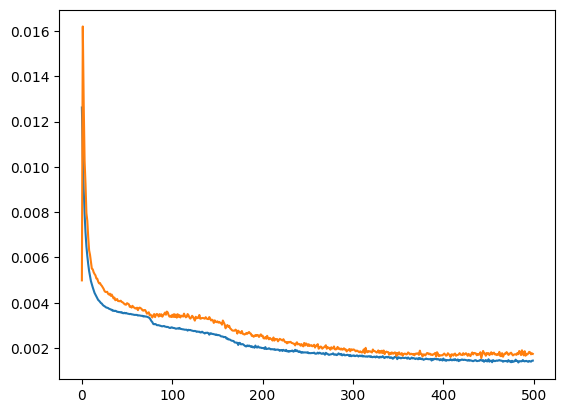

In [7]:
import matplotlib.pyplot as plt
plt.plot(history['loss'])
plt.plot(history['val_loss'])


In [8]:
model.load_state_dict(best_weights)
torch.save(best_weights, '../trained_weights/ResnetSISR_sparse_deep.pt')

/tmp/ipykernel_2360351/3935533979.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  t1 = torch.tensor(LR.view(1,1,64,64))


Text(0.5, 1.0, 'Train_Ground truth')

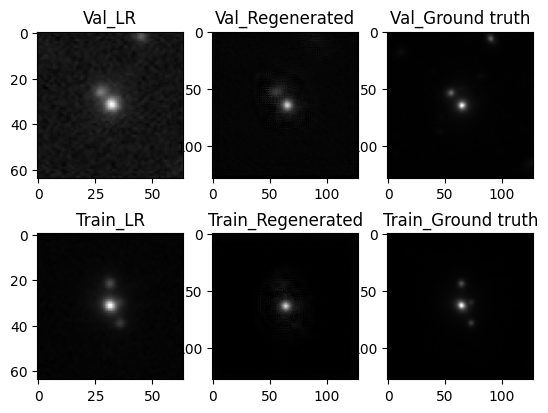

In [9]:
pre, post, tHR = show_random_image(val_dataset, model, 30)
pret, postt, tHRt = show_random_image(train_dataset, model, 270)
plot, axes = plt.subplots(2,3)
axes[0][0].imshow(pre)
axes[0][1].imshow(post)
axes[0][2].imshow(tHR)
axes[0][0].set_title("Val_LR")
axes[0][1].set_title("Val_Regenerated")
axes[0][2].set_title("Val_Ground truth")

axes[1][0].imshow(pret)
axes[1][1].imshow(postt)
axes[1][2].imshow(tHRt)
axes[1][0].set_title("Train_LR")
axes[1][1].set_title("Train_Regenerated")
axes[1][2].set_title("Train_Ground truth")